# IF867 - Introdução à Aprendizagem Profunda: Classificação de Tumores Cerebrais em Imagens de Ressonância Magnética com Redes Neurais Convolucionais

Discentes:
- Igor Costa da Silva Estevão de Azevedo (icsea)
- João Pedro Campos de Medeiros (jpcm2)
- Nathalia Fernanda de Araújo Barbosa (nfab)

## Imports das bibliotecas

In [ ]:
import os
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
from PIL import Image, UnidentifiedImageError

import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision
import pathlib

from skimage.io import imread
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import PIL.Image as Image

import kagglehub

## Download dos dados

In [ ]:
dataset_link = kagglehub.dataset_download('sartajbhuvaji/brain-tumor-classification-mri')

100%|██████████| 86.8M/86.8M [00:00<00:00, 145MB/s]

Extracting files...


In [ ]:
train_path = (f'{dataset_link}/Training/')
test_path = (f'{dataset_link}/Testing/')

## Análise exploratória dos dados de treinamento

### Classes existentes no dataset de treinamento

In [ ]:
train_dataset = datasets.ImageFolder(root=train_path)
classes = train_dataset.classes
print(f"Classes encontradas: {classes}")

Classes encontradas: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


### Plot de imagens presentes no dataset de treiamento

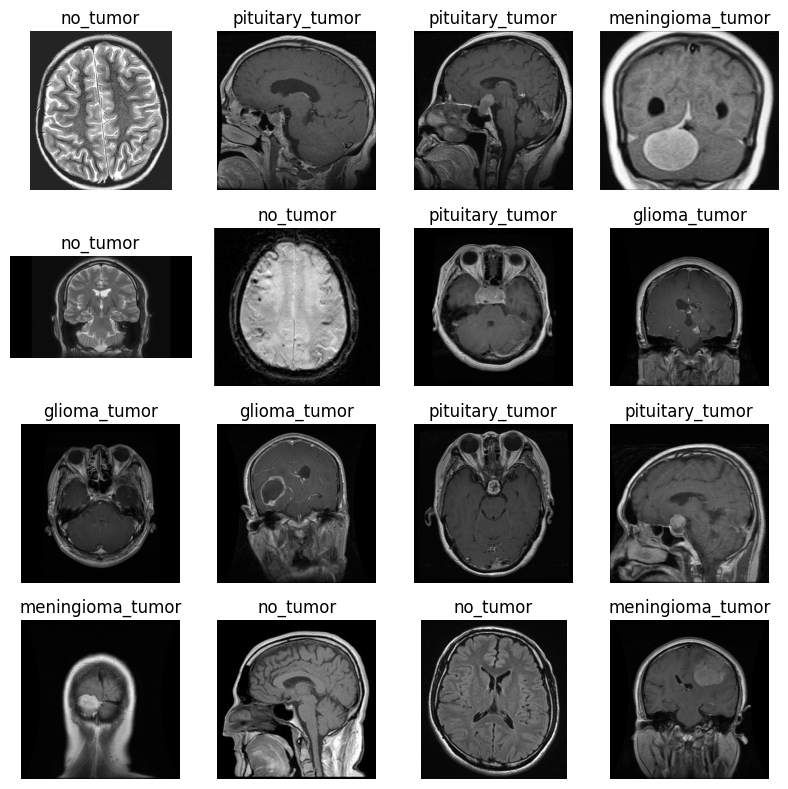

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.ravel()

for i in range(16):
    class_folder = random.choice(classes)
    class_path = pathlib.Path(train_path) / class_folder
    image_path = random.choice(list(class_path.glob("*.*")))  #Seleciona imagem aleatória
    img = Image.open(image_path)

    axes[i].imshow(img)
    axes[i].set_title(class_folder)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### Distribuição dos dados de treinamento
Ao analisar a distribuição dos dados de treinamento, notamos um desbalanceamento, especialmente quando comparamos o número de imagens da classe "no_tumor" (400) com as das demais classes (800 cada). No entanto, optamos por não realizar o rebalanceamento dos dados, pois acreditamos que essa alteração poderia afetar a representação real dos dados no contexto de uso prático. Além disso, técnicas como aumento de dados ou ajuste de pesos durante o treinamento podem ser mais adequadas para lidar com o desbalanceamento sem distorcer as distribuições naturais das classes.

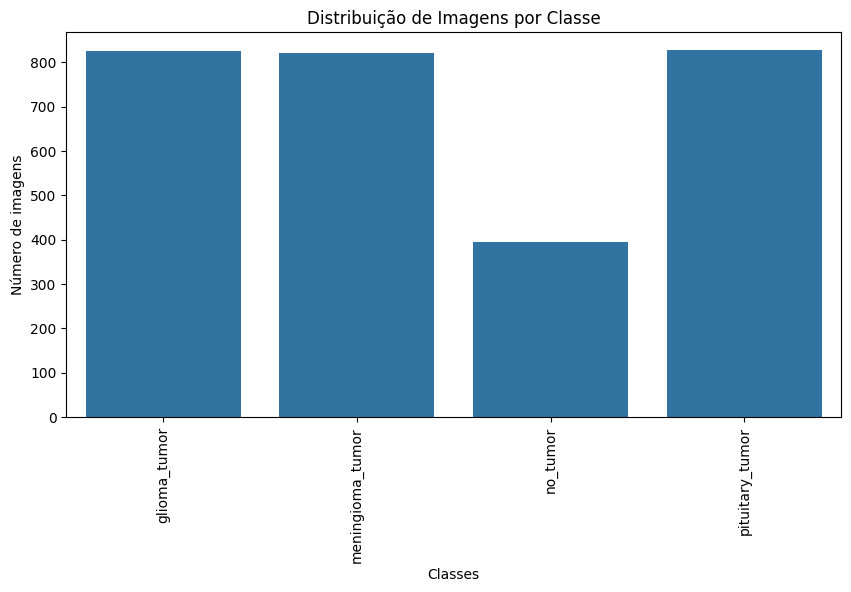

In [ ]:
# Contar número de imagens por classe
class_counts = collections.Counter(train_dataset.targets)

# Plotar a distribuição das classes
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=90)
plt.xlabel("Classes")
plt.ylabel("Número de imagens")
plt.title("Distribuição de Imagens por Classe")
plt.show()

### Verificação do tamanho das imagens
Observa-se no gráfico abaixo que as imagens possuem tamanhos variados. Sendo assim, é necessário redimensioná-las para um tamanho padrão durante a preparação dos dados, a fim de garantir consistência no processamento.

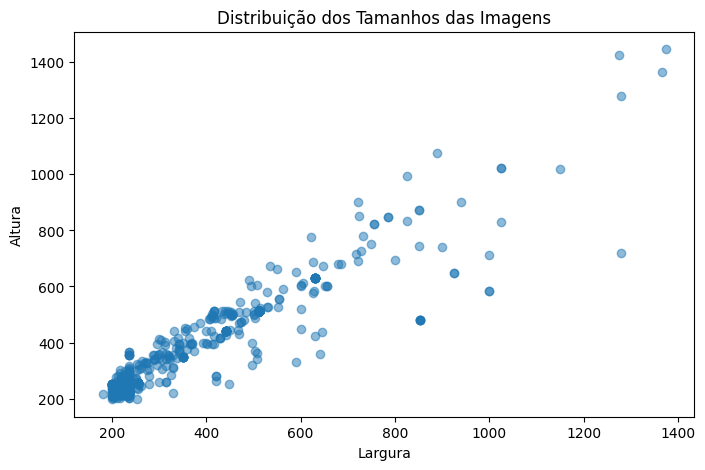

Tamanho médio das imagens: 480x481


In [ ]:
widths, heights = [], []

for img_path in pathlib.Path(train_path).rglob("*.*"):
    with Image.open(img_path) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

# Plotar a distribuição dos tamanhos
plt.figure(figsize=(8, 5))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.title("Distribuição dos Tamanhos das Imagens")
plt.show()

print(f"Tamanho médio das imagens: {sum(widths)//len(widths)}x{sum(heights)//len(heights)}")

### Checando se existem imagens corrompidas

In [ ]:
def check_corrupted_images(dataset_path):
    corrupted_files = []

    for img_path in pathlib.Path(dataset_path).rglob("*.*"):
        try:
            with Image.open(img_path) as img:
                img.verify()  # Verifica se a imagem é válida
        except (IOError, UnidentifiedImageError):
            corrupted_files.append(img_path)

    print(f"Imagens corrompidas encontradas: {len(corrupted_files)}")
    return corrupted_files

In [ ]:
corrupted_images = check_corrupted_images(train_path)

Imagens corrompidas encontradas: 0


Não foram detectadas imagens corrompidas no conjunto de dados de treinamento.

### Calculo da Média e Desvio Padrão dos Pixels
Esse cálculo é útil para definir os parâmetros da etapa de normalização, abordada na seção "Preparação dos dados".

In [ ]:
def compute_mean_std(dataset):
    pixel_sum = np.zeros(3)
    pixel_squared_sum = np.zeros(3)
    num_pixels = 0

    for img_path, _ in dataset.imgs:
        img = Image.open(img_path).convert("RGB")
        img = np.array(img) / 255.0  # Normalizar para [0,1]

        pixel_sum += img.mean(axis=(0, 1))
        pixel_squared_sum += (img ** 2).mean(axis=(0, 1))
        num_pixels += 1

    mean = pixel_sum / num_pixels
    std = np.sqrt(pixel_squared_sum / num_pixels - mean ** 2)
    return mean, std

In [ ]:
mean, std = compute_mean_std(train_dataset)
print(f"Média: {mean}")
print(f"Desvio Padrão: {std}")

Média: [0.17937622 0.17937622 0.17937622]
Desvio Padrão: [0.18951567 0.18951567 0.18951567]


## Preparação dos dados

Abaixo, implementamos a técnica de *augmentation* no código, com o objetivo de aumentar a variabilidade dos dados de entrada sem a necessidade de coletar novas imagens. Essa abordagem permite que o modelo se torne mais robusto, aprendendo a lidar com diferentes variações das imagens originais, como mudanças na orientação e no brilho.

No código, as transformações aplicadas são as seguintes:

1. **`transforms.Resize((150, 150))`**: Redimensiona a imagem para um tamanho fixo de 150x150 pixels. Isso padroniza todas as imagens para o mesmo formato.

2. **`transforms.RandomHorizontalFlip()`**: Aplica uma inversão horizontal aleatória na imagem. Essa técnica é útil para simular variações que podem ocorrer na orientação das imagens.

3. **`transforms.ToTensor()`**: Converte a imagem para o formato de tensor (um array multidimensional).

4. **`transforms.Normalize(mean, std)`**: Normaliza a imagem, subtraindo a média e dividindo pelo desvio padrão para cada canal de cor. No código, a média e o desvio padrão foram calculados previamente a partir do conjunto de dados, com valores aproximados de:

   - Média: [0.17937622, 0.17937622, 0.17937622]
   - Desvio padrão: [0.18951567, 0.18951567, 0.18951567]

   Essa normalização é importante porque ajuda o modelo a treinar de maneira mais eficiente, garantindo que as entradas tenham uma distribuição mais equilibrada e acelerando o processo de aprendizado.

Essas transformações são combinadas através da função `transforms.Compose()`, o que significa que todas as operações serão aplicadas em sequência na imagem antes de ser passada para o modelo. Com isso, conseguimos aumentar a diversidade dos dados de entrada, tornando o modelo mais robusto e menos propenso a overfitting.

In [ ]:
transforming_img = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.17937622, 0.17937622, 0.17937622],  # Média
                        [0.18951567, 0.18951567, 0.18951567])  # Desvio padrão
])

Em seguida, carrega o conjunto de dados de imagens para treinamento e teste, aplicando as transformações definidas (`transforming_img`). O `DataLoader` organiza as imagens em lotes e embaralha os dados no treinamento para melhorar a generalização do modelo.

In [ ]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transforming_img),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transforming_img),
    batch_size=32, shuffle=True
)

root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
print(f'Classes de tumores: {classes}') # Aqui devemos ter quatro classes, 'glioma_tumor', 'meningioma_tumor', 'no_tumor' e 'pituitary_tumor'

Classes de tumores: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


## Preparação do modelo

Número total de imagens para treinamento: 2870
Número total de imagens para teste: 394


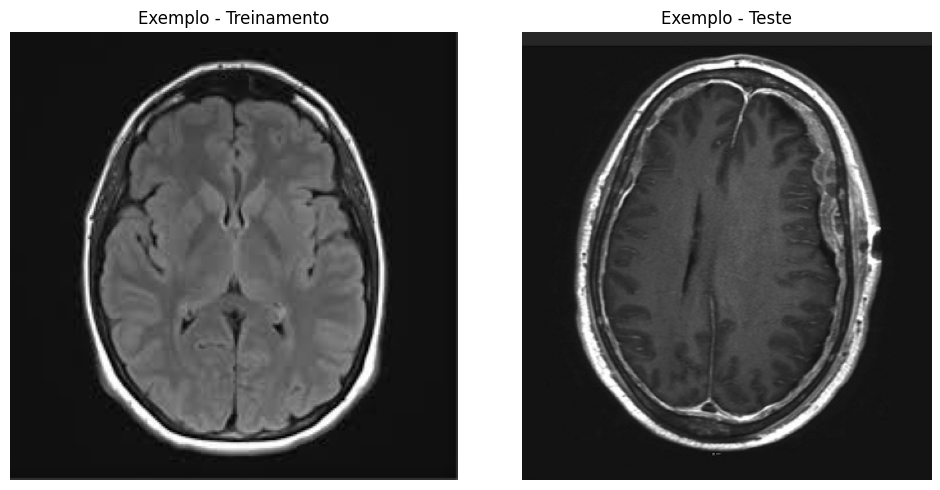

In [ ]:
# Função para contar imagens em um diretório considerando múltiplas extensões
def count_images(directory, extensions=("jpg", "jpeg", "png")):
    return sum(len(list(pathlib.Path(directory).rglob(f"*.{ext}"))) for ext in extensions)

# Função para obter um exemplo de imagem do diretório
def get_sample_image(directory, extensions=("jpg", "jpeg", "png")):
    for ext in extensions:
        image_list = list(pathlib.Path(directory).rglob(f"*.{ext}"))
        if image_list:
            return str(image_list[0])  # Retorna o caminho da primeira imagem encontrada
    return None

# Conta as imagens nos diretórios de treinamento e teste
train_count = count_images(train_path)
test_count = count_images(test_path)

# Exibe os resultados
print(f"Número total de imagens para treinamento: {train_count}")
print(f"Número total de imagens para teste: {test_count}")

# Obtém exemplos de imagens dos conjuntos de treinamento e teste
train_sample = get_sample_image(train_path)
test_sample = get_sample_image(test_path)

# Exibe as imagens lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 linha, 2 colunas

if train_sample:
    img = Image.open(train_sample)
    axes[0].imshow(img)
    axes[0].axis("off")
    axes[0].set_title("Exemplo - Treinamento")
else:
    axes[0].text(0.5, 0.5, "Sem imagem", ha="center", va="center", fontsize=12)
    axes[0].axis("off")

if test_sample:
    img = Image.open(test_sample)
    axes[1].imshow(img)
    axes[1].axis("off")
    axes[1].set_title("Exemplo - Teste")
else:
    axes[1].text(0.5, 0.5, "Sem imagem", ha="center", va="center", fontsize=12)
    axes[1].axis("off")

plt.tight_layout()
plt.show()

## Funções auxiliares

Nesta seção vamos implementar as funções que serão utilizadas para treinamento e plot dos resultados das CNNs.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Função para mover tensores para GPU ou CPU
def to_device(tensor, device):
    return tensor.to(device)

In [ ]:
def train(model, optimizer, loss_function, epochs, images, labels):
  best_accuracy = 0.0

  # Listas para armazenar os resultados
  train_losses = []
  train_accuracies = []
  test_accuracies = []

  # Treinamento e avaliação
  for epoch in range(epochs):  # Loop de épocas
      # Treinamento
      model.train()
      train_accuracy = 0.0
      train_loss = 0.0

      for i, (images, labels) in enumerate(train_loader):
          # Mover para o dispositivo correto (GPU ou CPU)
          images, labels = to_device(images, device), to_device(labels, device)

          optimizer.zero_grad()

          # Forward pass
          outputs = model(images)
          loss = loss_function(outputs, labels)

          # Backward pass e atualização dos pesos
          loss.backward()
          optimizer.step()

          # Atualizando as métricas de treinamento
          train_loss += loss.item() * images.size(0)  # Cálculo da perda ponderada pelo batch size
          _, prediction = torch.max(outputs.data, 1)
          train_accuracy += torch.sum(prediction == labels.data).item()

      # Normalizando a perda e a precisão
      train_accuracy /= train_count
      train_loss /= train_count

      # Avaliação
      model.eval()
      test_accuracy = 0.0

      with torch.no_grad():  # Desativa o cálculo de gradientes durante a avaliação
          for i, (images, labels) in enumerate(test_loader):
              # Mover para o dispositivo correto (GPU ou CPU)
              images, labels = to_device(images, device), to_device(labels, device)

              outputs = model(images)
              _, prediction = torch.max(outputs.data, 1)
              test_accuracy += torch.sum(prediction == labels.data).item()

      test_accuracy /= test_count

      # Armazenando os resultados
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      test_accuracies.append(test_accuracy)

      # Exibir resultados da época
      print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

      # Salvar o modelo se a precisão do teste for melhor
      if test_accuracy > best_accuracy:
          torch.save(model.state_dict(), 'best_checkpoint.model')
          best_accuracy = test_accuracy
  return train_losses, train_accuracies, test_accuracies, epochs

In [ ]:
def plot_results(train_losses, train_accuracies, test_accuracies, epochs):
    # Plotando os gráficos
    epochs = range(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    # Gráfico de perda de treinamento
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='b')
    plt.scatter(epochs, train_losses, color='b')  # Marcando os pontos de cada época
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss vs Epochs')
    plt.ylim(0.0, 3.0)
    plt.xticks(range(0, 21, 2))  # Ajustando os ticks do eixo X para 0 a 20 de 2 em 2
    plt.grid(True)  # Adicionando a grade para o gráfico de perda

    # Gráfico de precisão
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='g')
    plt.scatter(epochs, train_accuracies, color='g')  # Marcando os pontos de cada época
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='r')
    plt.scatter(epochs, test_accuracies, color='r')  # Marcando os pontos de cada época
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()
    plt.ylim(0.0, 1.0)  # Ajustando o eixo Y para ir de 0.0 até 1.0
    plt.xticks(range(0, 21, 2))  # Ajustando os ticks do eixo X para 0 a 20 de 2 em 2
    plt.grid(True)  # Adicionando a grade para o gráfico de acurácia

    plt.tight_layout()
    plt.show()


## Definição dos modelos

### CNN 1

A CNN (Convolutional Neural Network) definida aqui é uma rede projetada para classificação de imagens em **4 classes**. Começamos com uma rede bem simples para avaliar os resultados.

**Estrutura da Rede:**  
1. **Camadas Convolucionais**:  
   - A primeira convolução (`conv1`) aplica **32 filtros** de tamanho **3×3** e mantém o tamanho da imagem com `padding=1`.  
   - A segunda convolução (`conv2`) aplica **64 filtros** de tamanho **3×3**, também com `padding=1`.  

2. **Camada de Pooling**:  
   - Um **MaxPooling 2×2** reduz a dimensão da imagem pela metade, ajudando a reduzir a complexidade computacional.  

3. **Camadas totalmente conectadas (FC)**:  
   - A saída da convolução é achatada (`64 × 75 × 75`) e passada por uma camada totalmente conectada (`fc1`) com **128 neurônios**.  
   - A segunda camada totalmente conectada (`fc2`) reduz a saída para **4 neurônios**, correspondendo ao número de classes.  

4. **Funções de ativação e dropout**:  
   - `ReLU` é usado após cada convolução e camada densa para introduzir não-linearidade.  
   - Um `Dropout` de **50%** é aplicado antes da última camada para evitar overfitting.  

**Fluxo do Forward Pass:**
1. Aplica **conv1 → ReLU → MaxPooling**  
2. Aplica **conv2 → ReLU**  
3. Achata a saída e passa por **fc1 → ReLU → Dropout**  
4. Produz a saída final pela camada `fc2`.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 75 * 75, 128)
        self.fc2 = nn.Linear(128, 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        # print('Primeira camada', x.shape)
        x = self.relu(self.conv2(x))
        # print('Segunda camada', x.shape)
        x = x.view(x.size(0), -1)
        # print('Terceira camada', x.shape)
        x = self.relu(self.fc1(x))
        # print('Quarta camada', x.shape)
        x = self.dropout(x)
        # print('Quinta camada', x.shape)
        x = self.fc2(x)
        # print('Ultima camada', x.shape)
        return x

# Define o dispositivo de computação (GPU se disponível, senão CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo selecionado: {device}")

model=CNN().to(device)

Dispositivo selecionado: cpu


Durante o treinamento, se a máquina tiver uma GPU disponível, as imagens e labels serão enviadas para a GPU para aproveitar a aceleração de hardware.

In [ ]:
for i, (images,labels) in enumerate(train_loader):
    if torch.cuda.is_available():
        images=Variable(images.cuda())
        labels=Variable(labels.cuda())

In [ ]:
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
train_losses1, train_accuracies1, test_accuracies1, epochs1 = train(model, optimizer, nn.CrossEntropyLoss(), 20, images, labels)

Epoch 1: Train Loss: 2.8851, Train Accuracy: 0.4732, Test Accuracy: 0.3706
Epoch 2: Train Loss: 0.7719, Train Accuracy: 0.6760, Test Accuracy: 0.4010
Epoch 3: Train Loss: 0.6073, Train Accuracy: 0.7568, Test Accuracy: 0.5584
Epoch 4: Train Loss: 0.4804, Train Accuracy: 0.8035, Test Accuracy: 0.5533
Epoch 5: Train Loss: 0.4019, Train Accuracy: 0.8446, Test Accuracy: 0.5990
Epoch 6: Train Loss: 0.3307, Train Accuracy: 0.8679, Test Accuracy: 0.6599
Epoch 7: Train Loss: 0.2556, Train Accuracy: 0.9000, Test Accuracy: 0.6345
Epoch 8: Train Loss: 0.2262, Train Accuracy: 0.9146, Test Accuracy: 0.7030
Epoch 9: Train Loss: 0.2077, Train Accuracy: 0.9254, Test Accuracy: 0.6904
Epoch 10: Train Loss: 0.1951, Train Accuracy: 0.9303, Test Accuracy: 0.6954
Epoch 11: Train Loss: 0.1645, Train Accuracy: 0.9429, Test Accuracy: 0.7208
Epoch 12: Train Loss: 0.1321, Train Accuracy: 0.9537, Test Accuracy: 0.6878
Epoch 13: Train Loss: 0.1076, Train Accuracy: 0.9610, Test Accuracy: 0.7132
Epoch 14: Train Loss:

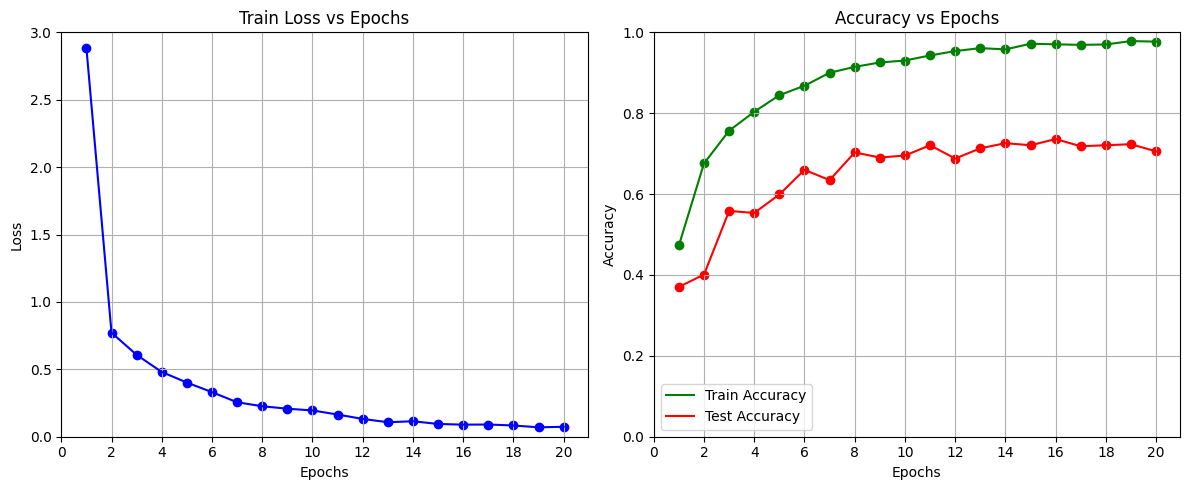

In [ ]:
plot_results(train_losses1, train_accuracies1, test_accuracies1, epochs1)

O modelo mostra uma melhoria consistente ao longo das épocas, com a perda de treino diminuindo e a acurácia de treino aumentando. A acurácia de teste, apesar de algumas flutuações, apresenta uma tendência de crescimento gradual.

Nos primeiros estágios, a acurácia de treino cresce de forma robusta, passando de 49,27% na primeira época para 97,46% na última. Por outro lado, a acurácia de teste começa em 36,80% e atinge 72,08% na última época. Embora a acurácia de teste tenha melhorado significativamente ao longo do tempo, ela ainda é mais baixa do que a de treino, o que pode indicar algum nível de overfitting.

Esse comportamento sugere que o modelo aprendeu bem os detalhes dos dados de treino, mas ainda pode ter dificuldade em generalizar para dados novos, já que a acurácia de teste não atinge os mesmos níveis da acurácia de treino.

### CNN 2

Vamos agora implementar um modelo CNN mais robusto, com camadas adicionais e técnicas de regularização para melhorar o desempenho e a capacidade de generalização do modelo.

A nova arquitetura da rede foi projetada com mais camadas convolucionais e de normalização, o que contribui para a extração de características mais complexas das imagens.

**Estrutura da Rede:**  
1. **Camadas Convolucionais**:  
   - A primeira convolução (`conv1`) aplica **64 filtros** de tamanho **5×5** com `padding=2`, garantindo que a imagem de entrada mantenha as dimensões após a convolução.  
   - A segunda convolução (`conv2`) aplica **128 filtros** de tamanho **3×3** com `padding=1`.  
   - A terceira convolução (`conv3`) aplica **256 filtros** de tamanho **3×3** com `padding=1`.  
   - A quarta convolução (`conv4`) aplica **512 filtros** de tamanho **3×3** com `padding=1`.  

2. **Camadas de Normalização e Pooling**:  
   - Cada camada convolucional é seguida por **Batch Normalization** (ex: `bn1`, `bn2`, `bn3`, `bn4`), o que ajuda a estabilizar o treinamento e acelerar a convergência.  
   - Após cada convolução e normalização, aplica-se um **MaxPooling 2×2** com stride de 2, reduzindo as dimensões espaciais da imagem e extraindo as características mais importantes.

3. **Camadas totalmente conectadas (FC)**:  
   - Após o pooling, a saída é achatada para um vetor e passada pela primeira camada totalmente conectada (`fc1`), que possui **512 neurônios**.  
   - A segunda camada totalmente conectada (`fc2`) reduz a saída para **256 neurônios**.  
   - A terceira camada totalmente conectada (`fc3`) possui **128 neurônios**.  
   - A camada final de saída (`fc4`) possui **4 neurônios**, correspondendo ao número de classes do problema de classificação.

4. **Funções de ativação e regularização**:  
   - A função **ReLU** é aplicada após cada camada convolucional e camada totalmente conectada para introduzir não-linearidade no modelo.  
   - A técnica de **Dropout** é aplicada com uma taxa de **30%** após as camadas totalmente conectadas (`fc1`, `fc2` e `fc3`) para evitar overfitting e melhorar a generalização do modelo.

**Fluxo do Forward Pass:**
1. Aplica **conv1 → BatchNorm → ReLU → MaxPooling**  
2. Aplica **conv2 → BatchNorm → ReLU → MaxPooling**  
3. Aplica **conv3 → BatchNorm → ReLU → MaxPooling**  
4. Aplica **conv4 → BatchNorm → ReLU → MaxPooling**  
5. Achata a saída e passa por **fc1 → ReLU → Dropout**  
6. Passa por **fc2 → ReLU → Dropout**  
7. Passa por **fc3 → ReLU → Dropout**  
8. Produz a saída final pela camada `fc4`.

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 4)

        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x

# Define o dispositivo de computação (GPU se disponível, senão CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo selecionado: {device}")

model=ImprovedCNN().to(device)

Dispositivo selecionado: cpu


In [ ]:
for i, (images,labels) in enumerate(train_loader):
    if torch.cuda.is_available():
        images=Variable(images.cuda())
        labels=Variable(labels.cuda())

In [ ]:
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
train_losses2, train_accuracies2, test_accuracies2, epochs2 = train(model, optimizer, nn.CrossEntropyLoss(), 20, images, labels)

Epoch 1: Train Loss: 1.3701, Train Accuracy: 0.4767, Test Accuracy: 0.2487
Epoch 2: Train Loss: 0.8332, Train Accuracy: 0.6383, Test Accuracy: 0.3934
Epoch 3: Train Loss: 0.6945, Train Accuracy: 0.7181, Test Accuracy: 0.3782
Epoch 4: Train Loss: 0.6393, Train Accuracy: 0.7422, Test Accuracy: 0.4112
Epoch 5: Train Loss: 0.5805, Train Accuracy: 0.7624, Test Accuracy: 0.4645
Epoch 6: Train Loss: 0.5142, Train Accuracy: 0.7889, Test Accuracy: 0.3731
Epoch 7: Train Loss: 0.4543, Train Accuracy: 0.8125, Test Accuracy: 0.4442
Epoch 8: Train Loss: 0.4219, Train Accuracy: 0.8254, Test Accuracy: 0.4619
Epoch 9: Train Loss: 0.3869, Train Accuracy: 0.8425, Test Accuracy: 0.4188
Epoch 10: Train Loss: 0.3431, Train Accuracy: 0.8564, Test Accuracy: 0.5660
Epoch 11: Train Loss: 0.3504, Train Accuracy: 0.8610, Test Accuracy: 0.4924
Epoch 12: Train Loss: 0.3103, Train Accuracy: 0.8718, Test Accuracy: 0.5279
Epoch 13: Train Loss: 0.2953, Train Accuracy: 0.8826, Test Accuracy: 0.4797
Epoch 14: Train Loss:

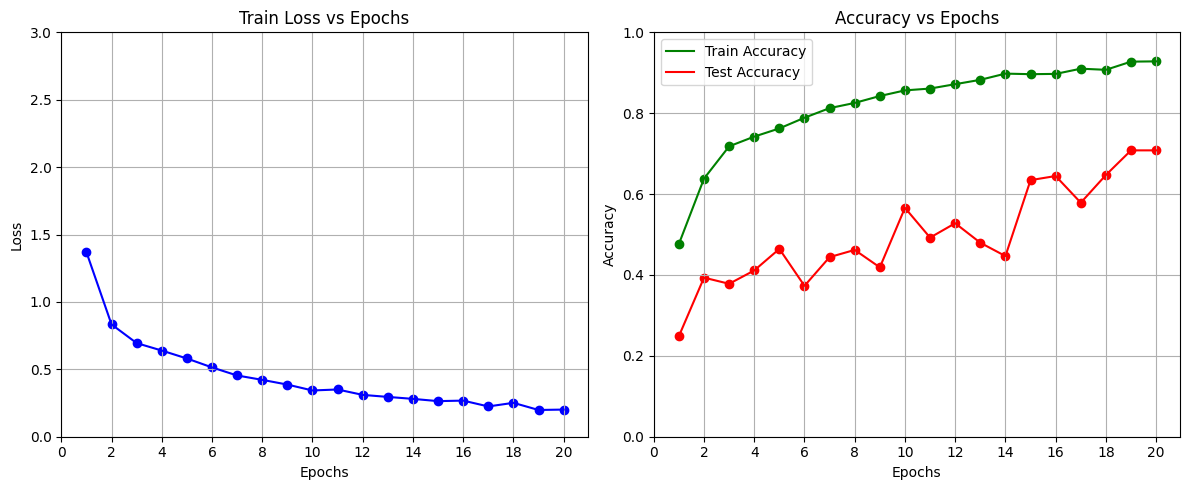

In [ ]:
plot_results(train_losses2, train_accuracies2, test_accuracies2, epochs2)

### ConvNet

In [ ]:
class ConvNet(nn.Module):
     def __init__(self,num_classes=4):
         super(ConvNet,self).__init__()
         self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
         self.bn1=nn.BatchNorm2d(num_features=12)
         self.relu1=nn.ReLU()
         self.pool=nn.MaxPool2d(kernel_size=2)
         self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
         self.relu2=nn.ReLU()
         self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
         self.bn3=nn.BatchNorm2d(num_features=32)
         self.relu3=nn.ReLU()
         self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)

     def forward(self,input):
         output=self.conv1(input)
         output=self.bn1(output)
         output=self.relu1(output)
         output=self.pool(output)
         output=self.conv2(output)
         output=self.relu2(output)
         output=self.conv3(output)
         output=self.bn3(output)
         output=self.relu3(output)
         output=output.view(-1,32*75*75)
         output=self.fc(output)

         return output
# Define o dispositivo de computação (GPU se disponível, senão CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo selecionado: {device}")

model=ConvNet().to(device)

Dispositivo selecionado: cpu


In [ ]:
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
train_losses3, train_accuracies3, test_accuracies3, epochs3 = train(model, optimizer, nn.CrossEntropyLoss(), 20, images, labels)

Epoch 1: Train Loss: 6.4861, Train Accuracy: 0.6000, Test Accuracy: 0.5025
Epoch 2: Train Loss: 1.9397, Train Accuracy: 0.7624, Test Accuracy: 0.5355
Epoch 3: Train Loss: 0.8524, Train Accuracy: 0.8620, Test Accuracy: 0.6041
Epoch 4: Train Loss: 0.4234, Train Accuracy: 0.9132, Test Accuracy: 0.6371
Epoch 5: Train Loss: 0.2648, Train Accuracy: 0.9352, Test Accuracy: 0.6015
Epoch 6: Train Loss: 0.2325, Train Accuracy: 0.9422, Test Accuracy: 0.7081
Epoch 7: Train Loss: 0.3063, Train Accuracy: 0.9387, Test Accuracy: 0.6980
Epoch 8: Train Loss: 0.4284, Train Accuracy: 0.9303, Test Accuracy: 0.5533
Epoch 9: Train Loss: 0.2941, Train Accuracy: 0.9467, Test Accuracy: 0.6396
Epoch 10: Train Loss: 0.2173, Train Accuracy: 0.9582, Test Accuracy: 0.7005
Epoch 11: Train Loss: 0.1514, Train Accuracy: 0.9679, Test Accuracy: 0.7005
Epoch 12: Train Loss: 0.2552, Train Accuracy: 0.9505, Test Accuracy: 0.6827
Epoch 13: Train Loss: 0.0699, Train Accuracy: 0.9822, Test Accuracy: 0.7437
Epoch 14: Train Loss:

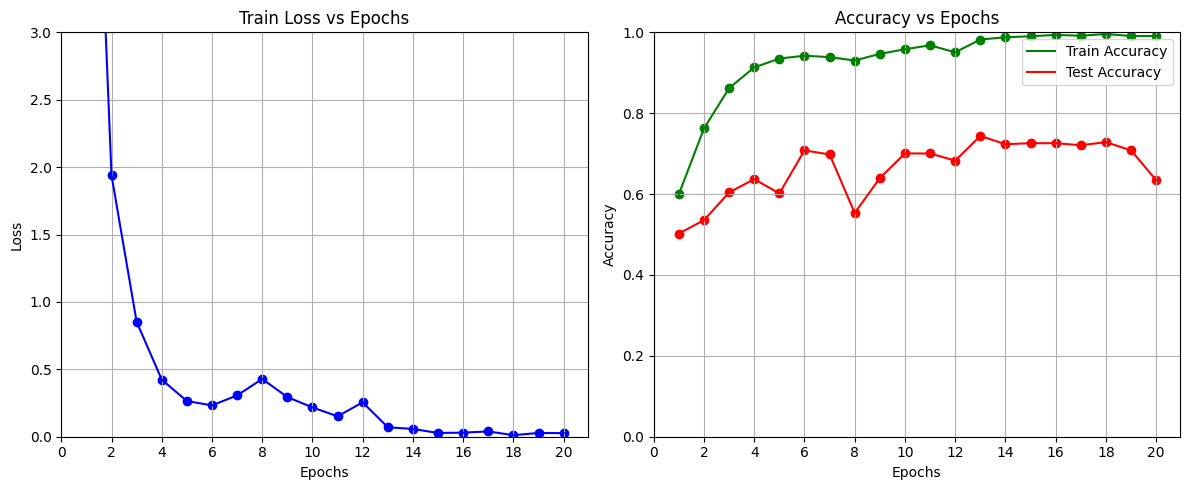

In [ ]:
plot_results(train_losses3, train_accuracies3, test_accuracies3, epochs3)

# 🧪 Experimentos

### Primeiramente vamos ajustar as CNNs 1 e 2 para podermos editar seus hiperparâmetros

In [ ]:
class CNN1(nn.Module):
    def __init__(self, conv1_out=32, conv2_out=64, fc1_out=128, dropout_rate=0.5):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, conv1_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(conv2_out * 75 * 75, fc1_out)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc1_out, 4)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
class ImprovedCNN1(nn.Module):
    def __init__(self, conv_channels, kernel_sizes, fc_units, dropout_rate):
        super(ImprovedCNN1, self).__init__()

        # unpack hiperparams
        c1, c2, c3, c4 = conv_channels
        k1, k2, k3, k4 = kernel_sizes
        f1, f2, f3 = fc_units

        self.conv1 = nn.Conv2d(3, c1, kernel_size=k1, padding=k1//2)
        self.bn1 = nn.BatchNorm2d(c1)

        self.conv2 = nn.Conv2d(c1, c2, kernel_size=k2, padding=k2//2)
        self.bn2 = nn.BatchNorm2d(c2)

        self.conv3 = nn.Conv2d(c2, c3, kernel_size=k3, padding=k3//2)
        self.bn3 = nn.BatchNorm2d(c3)

        self.conv4 = nn.Conv2d(c3, c4, kernel_size=k4, padding=k4//2)
        self.bn4 = nn.BatchNorm2d(c4)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        # Após 4 pools, imagem de 150x150 vira 9x9
        self.flatten_size = c4 * 9 * 9

        self.fc1 = nn.Linear(self.flatten_size, f1)
        self.fc2 = nn.Linear(f1, f2)
        self.fc3 = nn.Linear(f2, f3)
        self.fc4 = nn.Linear(f3, 4)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


#### Importando as bibliotecas necessárias para fazer uso do Optuna para os experimentos

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 14.3 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

#### Função para realizar o tuning de hiperparâmetros da CNN 1

In [ ]:
def objective_CNN1(trial):
    # Hiperparâmetros mais importantes e simples
    conv1_out = trial.suggest_categorical("conv1_out", [16, 32])
    conv2_out = trial.suggest_categorical("conv2_out", [32, 64])
    fc1_out = trial.suggest_categorical("fc1_out", [64, 128])
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.5)

    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True)
    wd = trial.suggest_float("wd", 1e-6, 1e-4, log=True)

    model = CNN1(conv1_out, conv2_out, fc1_out, dropout_rate).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_function = nn.CrossEntropyLoss()

    # Usa sua função personalizada
    train_losses, train_accuracies, test_accuracies, _ = train(
        model=model,
        optimizer=optimizer,
        loss_function=loss_function,
        epochs=3,  # rápido para tuning leve
        images=None,
        labels=None
    )

    return max(test_accuracies)


#### Função para fazer o tuning de hiperparâmetros da CNN 2

In [ ]:
def objective_improved(trial):
    # Foco só nos hiperparâmetros mais impactantes
    conv_channels = [
        trial.suggest_categorical("conv1_out", [32, 64]),
        128,
        256,
        trial.suggest_categorical("conv4_out", [256, 512]),
    ]

    kernel_sizes = [3, 3, 3, 3]  # fixo (evita combinatória desnecessária)

    fc_units = [
        trial.suggest_categorical("fc1", [256, 512]),
        256,  # fixo
        trial.suggest_categorical("fc3", [64, 128]),
    ]

    dropout_rate = trial.suggest_float("dropout", 0.3, 0.5)

    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True)
    wd = trial.suggest_float("wd", 1e-6, 1e-4, log=True)

    # Modelo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ImprovedCNN1(conv_channels, kernel_sizes, fc_units, dropout_rate).to(device)

    # Otimizador (sem grupos para simplificar)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_function = nn.CrossEntropyLoss()

    train_losses, train_accuracies, test_accuracies, _ = train(
        model=model,
        optimizer=optimizer,
        loss_function=loss_function,
        epochs=3,
        images=None,
        labels=None
    )

    return max(test_accuracies)


#### Realizando o trial do optuna

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_CNN1, n_trials=10)

print("Melhores hiperparâmetros:")
print(study.best_params)


[I 2025-03-24 14:12:56,001] A new study created in memory with name: no-name-cd52c0d4-c5d5-4c76-a08a-9caf962abf0d


Epoch 1: Train Loss: 1.0532, Train Accuracy: 0.5958, Test Accuracy: 0.4010
Epoch 2: Train Loss: 0.6487, Train Accuracy: 0.7453, Test Accuracy: 0.4619
Epoch 3: Train Loss: 0.5061, Train Accuracy: 0.8077, Test Accuracy: 0.5812


[I 2025-03-24 14:17:42,848] Trial 0 finished with value: 0.5812182741116751 and parameters: {'conv1_out': 16, 'conv2_out': 32, 'fc1_out': 128, 'dropout': 0.39617451404839144, 'lr': 0.0003387947923352625, 'wd': 3.2635057173675675e-06}. Best is trial 0 with value: 0.5812182741116751.


Epoch 1: Train Loss: 0.9768, Train Accuracy: 0.5822, Test Accuracy: 0.4391
Epoch 2: Train Loss: 0.6871, Train Accuracy: 0.7216, Test Accuracy: 0.4822


[I 2025-03-24 14:24:32,790] Trial 1 finished with value: 0.5482233502538071 and parameters: {'conv1_out': 32, 'conv2_out': 32, 'fc1_out': 64, 'dropout': 0.31791719524635215, 'lr': 0.00013529125851232407, 'wd': 1.2856533965993058e-05}. Best is trial 0 with value: 0.5812182741116751.


Epoch 3: Train Loss: 0.5641, Train Accuracy: 0.7686, Test Accuracy: 0.5482
Epoch 1: Train Loss: 3.0185, Train Accuracy: 0.5387, Test Accuracy: 0.4036
Epoch 2: Train Loss: 0.6519, Train Accuracy: 0.7439, Test Accuracy: 0.5508
Epoch 3: Train Loss: 0.4642, Train Accuracy: 0.8286, Test Accuracy: 0.6218


[I 2025-03-24 14:31:56,931] Trial 2 finished with value: 0.6218274111675127 and parameters: {'conv1_out': 16, 'conv2_out': 64, 'fc1_out': 128, 'dropout': 0.37855681730661594, 'lr': 0.0006330738482453748, 'wd': 1.1807350280943506e-05}. Best is trial 2 with value: 0.6218274111675127.


Epoch 1: Train Loss: 1.8887, Train Accuracy: 0.4801, Test Accuracy: 0.3299
Epoch 2: Train Loss: 0.7326, Train Accuracy: 0.7014, Test Accuracy: 0.4036
Epoch 3: Train Loss: 0.5981, Train Accuracy: 0.7561, Test Accuracy: 0.5330


[I 2025-03-24 14:40:47,297] Trial 3 finished with value: 0.5329949238578681 and parameters: {'conv1_out': 32, 'conv2_out': 64, 'fc1_out': 64, 'dropout': 0.49492819814021893, 'lr': 0.000603801879741115, 'wd': 1.7794473885136956e-06}. Best is trial 2 with value: 0.6218274111675127.


Epoch 1: Train Loss: 1.2770, Train Accuracy: 0.4965, Test Accuracy: 0.3756
Epoch 2: Train Loss: 0.7630, Train Accuracy: 0.6833, Test Accuracy: 0.3832
Epoch 3: Train Loss: 0.6128, Train Accuracy: 0.7516, Test Accuracy: 0.4949


[I 2025-03-24 14:47:56,943] Trial 4 finished with value: 0.4949238578680203 and parameters: {'conv1_out': 32, 'conv2_out': 32, 'fc1_out': 128, 'dropout': 0.4391184964394307, 'lr': 0.00046190822170952744, 'wd': 6.512893860940866e-06}. Best is trial 2 with value: 0.6218274111675127.


Epoch 1: Train Loss: 1.0743, Train Accuracy: 0.5725, Test Accuracy: 0.3579
Epoch 2: Train Loss: 0.6201, Train Accuracy: 0.7547, Test Accuracy: 0.4569
Epoch 3: Train Loss: 0.4723, Train Accuracy: 0.8160, Test Accuracy: 0.5609


[I 2025-03-24 14:55:17,956] Trial 5 finished with value: 0.5609137055837563 and parameters: {'conv1_out': 32, 'conv2_out': 32, 'fc1_out': 128, 'dropout': 0.3455129294576662, 'lr': 0.00028591283358099886, 'wd': 5.961390028632727e-06}. Best is trial 2 with value: 0.6218274111675127.


Epoch 1: Train Loss: 1.1514, Train Accuracy: 0.5226, Test Accuracy: 0.3807
Epoch 2: Train Loss: 0.7842, Train Accuracy: 0.6767, Test Accuracy: 0.4036


[I 2025-03-24 15:01:47,675] Trial 6 finished with value: 0.5253807106598984 and parameters: {'conv1_out': 32, 'conv2_out': 32, 'fc1_out': 64, 'dropout': 0.4378856210222031, 'lr': 0.00036072527884296505, 'wd': 1.2238567725015006e-06}. Best is trial 2 with value: 0.6218274111675127.


Epoch 3: Train Loss: 0.6581, Train Accuracy: 0.7289, Test Accuracy: 0.5254
Epoch 1: Train Loss: 1.0514, Train Accuracy: 0.5547, Test Accuracy: 0.3274
Epoch 2: Train Loss: 0.7289, Train Accuracy: 0.7101, Test Accuracy: 0.4695


[I 2025-03-24 15:06:36,253] Trial 7 finished with value: 0.46954314720812185 and parameters: {'conv1_out': 16, 'conv2_out': 32, 'fc1_out': 128, 'dropout': 0.4686146614890527, 'lr': 0.00012253775047409664, 'wd': 1.1225918731111477e-05}. Best is trial 2 with value: 0.6218274111675127.


Epoch 3: Train Loss: 0.6198, Train Accuracy: 0.7509, Test Accuracy: 0.4594
Epoch 1: Train Loss: 1.5328, Train Accuracy: 0.4481, Test Accuracy: 0.3553
Epoch 2: Train Loss: 0.8886, Train Accuracy: 0.6355, Test Accuracy: 0.3731
Epoch 3: Train Loss: 0.7285, Train Accuracy: 0.6780, Test Accuracy: 0.5305


[I 2025-03-24 15:15:08,643] Trial 8 finished with value: 0.5304568527918782 and parameters: {'conv1_out': 32, 'conv2_out': 64, 'fc1_out': 64, 'dropout': 0.44388565334479113, 'lr': 0.00042195802411576223, 'wd': 4.923866443100358e-05}. Best is trial 2 with value: 0.6218274111675127.


Epoch 1: Train Loss: 1.5145, Train Accuracy: 0.5418, Test Accuracy: 0.2614
Epoch 2: Train Loss: 0.6606, Train Accuracy: 0.7310, Test Accuracy: 0.4061
Epoch 3: Train Loss: 0.5178, Train Accuracy: 0.7868, Test Accuracy: 0.5533


[I 2025-03-24 15:25:34,966] Trial 9 finished with value: 0.5532994923857868 and parameters: {'conv1_out': 32, 'conv2_out': 64, 'fc1_out': 128, 'dropout': 0.373446402349937, 'lr': 0.00036729224722837614, 'wd': 3.4348336749013884e-05}. Best is trial 2 with value: 0.6218274111675127.


Melhores hiperparâmetros:
{'conv1_out': 16, 'conv2_out': 64, 'fc1_out': 128, 'dropout': 0.37855681730661594, 'lr': 0.0006330738482453748, 'wd': 1.1807350280943506e-05}


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_improved, n_trials=8)

print("Melhores hiperparâmetros:")
print(study.best_params)


[I 2025-03-24 15:33:25,220] A new study created in memory with name: no-name-d1063dc8-b0a6-420d-9c5b-5a5bde2c5305


Epoch 1: Train Loss: 1.0009, Train Accuracy: 0.5641, Test Accuracy: 0.4518
Epoch 2: Train Loss: 0.7099, Train Accuracy: 0.6958, Test Accuracy: 0.3782


[I 2025-03-24 16:06:40,006] Trial 0 finished with value: 0.4517766497461929 and parameters: {'conv1_out': 32, 'conv4_out': 512, 'fc1': 256, 'fc3': 128, 'dropout': 0.3151116497164607, 'lr': 0.00030006531874319814, 'wd': 3.972582000485255e-05}. Best is trial 0 with value: 0.4517766497461929.


Epoch 3: Train Loss: 0.6153, Train Accuracy: 0.7373, Test Accuracy: 0.3223
Epoch 1: Train Loss: 1.1709, Train Accuracy: 0.5014, Test Accuracy: 0.2741
Epoch 2: Train Loss: 0.8357, Train Accuracy: 0.6383, Test Accuracy: 0.3046


[I 2025-03-24 16:36:32,402] Trial 1 finished with value: 0.3477157360406091 and parameters: {'conv1_out': 32, 'conv4_out': 512, 'fc1': 256, 'fc3': 64, 'dropout': 0.3862348775280033, 'lr': 0.00045790065331368534, 'wd': 1.1236912860033185e-05}. Best is trial 0 with value: 0.4517766497461929.


Epoch 3: Train Loss: 0.6808, Train Accuracy: 0.7111, Test Accuracy: 0.3477
Epoch 1: Train Loss: 0.9990, Train Accuracy: 0.5627, Test Accuracy: 0.3706
Epoch 2: Train Loss: 0.7042, Train Accuracy: 0.7035, Test Accuracy: 0.3452


[I 2025-03-24 17:09:29,184] Trial 2 finished with value: 0.4035532994923858 and parameters: {'conv1_out': 64, 'conv4_out': 256, 'fc1': 256, 'fc3': 128, 'dropout': 0.3735125558882446, 'lr': 0.00026000790886851477, 'wd': 4.281405971639236e-05}. Best is trial 0 with value: 0.4517766497461929.


Epoch 3: Train Loss: 0.5564, Train Accuracy: 0.7718, Test Accuracy: 0.4036
Epoch 1: Train Loss: 1.2637, Train Accuracy: 0.5024, Test Accuracy: 0.2665
Epoch 2: Train Loss: 0.8463, Train Accuracy: 0.6432, Test Accuracy: 0.2919
Epoch 3: Train Loss: 0.7224, Train Accuracy: 0.6892, Test Accuracy: 0.3579


[I 2025-03-24 17:47:41,350] Trial 3 finished with value: 0.35786802030456855 and parameters: {'conv1_out': 64, 'conv4_out': 512, 'fc1': 512, 'fc3': 64, 'dropout': 0.3980915152144901, 'lr': 0.0007478276894393693, 'wd': 2.5773253680559855e-06}. Best is trial 0 with value: 0.4517766497461929.


Epoch 1: Train Loss: 1.0601, Train Accuracy: 0.5383, Test Accuracy: 0.2970
Epoch 2: Train Loss: 0.7525, Train Accuracy: 0.6753, Test Accuracy: 0.4416


[I 2025-03-24 18:13:31,644] Trial 4 finished with value: 0.44923857868020306 and parameters: {'conv1_out': 32, 'conv4_out': 256, 'fc1': 512, 'fc3': 128, 'dropout': 0.31753633334267006, 'lr': 0.0008321712461406259, 'wd': 2.804952733024694e-05}. Best is trial 0 with value: 0.4517766497461929.


Epoch 3: Train Loss: 0.5968, Train Accuracy: 0.7373, Test Accuracy: 0.4492
Epoch 1: Train Loss: 1.0849, Train Accuracy: 0.5272, Test Accuracy: 0.3401
Epoch 2: Train Loss: 0.7480, Train Accuracy: 0.6756, Test Accuracy: 0.3832


[I 2025-03-24 18:39:30,456] Trial 5 finished with value: 0.5076142131979695 and parameters: {'conv1_out': 32, 'conv4_out': 256, 'fc1': 512, 'fc3': 128, 'dropout': 0.39900700259597355, 'lr': 0.0006873235460444953, 'wd': 2.1561683994021872e-05}. Best is trial 5 with value: 0.5076142131979695.


Epoch 3: Train Loss: 0.6310, Train Accuracy: 0.7345, Test Accuracy: 0.5076
Epoch 1: Train Loss: 1.0233, Train Accuracy: 0.5449, Test Accuracy: 0.3046
Epoch 2: Train Loss: 0.7184, Train Accuracy: 0.7031, Test Accuracy: 0.3579


[I 2025-03-24 19:18:11,768] Trial 6 finished with value: 0.35786802030456855 and parameters: {'conv1_out': 64, 'conv4_out': 512, 'fc1': 256, 'fc3': 128, 'dropout': 0.3959202905327449, 'lr': 0.0002129308406378229, 'wd': 1.9138788391214726e-06}. Best is trial 5 with value: 0.5076142131979695.


Epoch 3: Train Loss: 0.6044, Train Accuracy: 0.7425, Test Accuracy: 0.3503
Epoch 1: Train Loss: 1.2497, Train Accuracy: 0.4711, Test Accuracy: 0.2614
Epoch 2: Train Loss: 0.8583, Train Accuracy: 0.6233, Test Accuracy: 0.2538
Epoch 3: Train Loss: 0.7441, Train Accuracy: 0.6652, Test Accuracy: 0.3249


[I 2025-03-24 19:48:24,667] Trial 7 finished with value: 0.3248730964467005 and parameters: {'conv1_out': 32, 'conv4_out': 512, 'fc1': 512, 'fc3': 64, 'dropout': 0.4738725148053578, 'lr': 0.000495884489656496, 'wd': 1.380734287444718e-05}. Best is trial 5 with value: 0.5076142131979695.


Melhores hiperparâmetros:
{'conv1_out': 32, 'conv4_out': 256, 'fc1': 512, 'fc3': 128, 'dropout': 0.39900700259597355, 'lr': 0.0006873235460444953, 'wd': 2.1561683994021872e-05}


### Nesta etapa iremos fazer experimentos com novas metodologias como transfer learning, fine tuning, criação de um novo modelo e utilização de um

#### Preparação dos dados

Nesta etapa estamos definindo alguns hiperparâmetros para que possamos usar na nossa experimentação, como por exemplo a utilização de regularização. Além disso, também estamos definindo o dispositivo de hardware que iremos utilizar.

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

# Configurando hiperparâmetros.
args = {
    'epoch_num': 20,      # Número de épocas
    'lr': 1e-2,           # Taxa de aprendizado
    'num_classes': 4,    # Nº de classes
    'weight_decay': 8e-4, # Regularização
    'batch_size': 32,     # Tamanho do batch
}

# Definindo dispositivo de hardware
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])
# # Habilita Mixed Precision e otimizações do PyTorch 2.0+
# if torch.__version__ >= "2.0":
#     torch.set_float32_matmul_precision('high')

cpu


Aqui estamos utilizando a mesma transformação de dados da ImageNet, já que também iremos fazer uso de modelos pre-treinados.

In [ ]:
transform_train_exp = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_exp = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_loader_exp=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transform_train_exp),
    batch_size=args['batch_size'],
    shuffle=True
)
test_loader_exp=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transform_val_exp),
    batch_size=args['batch_size'],
    shuffle=True
)


Verificando a ordem do dataset para exibir no classification report

In [ ]:
dataset_exp = torchvision.datasets.ImageFolder(test_path,transform=transform_val_exp)
print(dataset_exp.class_to_idx)
class_names = dataset_exp.classes
print(class_names)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
from torch import nn, optim
import time, os
from sklearn.metrics import f1_score, classification_report

#### Funções

Definindo a função de treinamento que iremos usar nos testes de novas redes e modelos pre treinados.

- Essa função recebe:

 - train_loader: o DataLoader com os dados de treino.

 - net: o modelo neural que será treinado.

 - epoch: o número da época atual (usado apenas para print).

- Ela faz:
 - Coloca o modelo em modo de treino
 - Inicia um dicionário para salvar histórico de loss e a acurácia
 - Faz o loop sobre os batches:
    - divide cada batch em imagens (dado) e rótulos (rotulo).
    - Envia para GPU (ou CPU) com .to(args['device'])
 - Executa o modelo sobre as imagens (dado) e calcula o loss
 - Zera os gradientes anteriores, calcula os gradientes via backprop e atualiza os pesos do modelo com optimizer
 - Salva a perda do batch, e as predições/rótulos para calcular a acurácia da época
 - Concatena os resultados de todos os batches e calcula a acurácia final da época.
 - Mostra as estatísticas da época (loss médio, desvio padrão, acurácia)
- Retorna:
 - Acurácia
 - Loss Médio
 - Dicionário com histórico da época

In [ ]:
def train_exp(train_loader, net, epoch):

    # Training mode
    net.train()
    history = {'loss': [], 'accuracy': []}

    epoch_loss  = []
    pred_list, rotulo_list = [], []
    for k, batch in enumerate(train_loader):
        print('\r--{0}/{1}--'.format(k, len(train_loader)), end='', flush=True)
        dado, rotulo = batch

        # Cast do dado na GPU
        dado = dado.to(args['device'])
        rotulo = rotulo.to(args['device'])

        # Forward
        ypred = net(dado)
        # print(ypred.size(), rotulo.size())
        loss = criterion(ypred, rotulo)
        # print(loss.size())
        epoch_loss.append(loss.cpu().data)

        _, pred = torch.max(ypred, axis=1)
        pred_list.append(pred.cpu().numpy())
        rotulo_list.append(rotulo.cpu().numpy())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = np.asarray(epoch_loss)
    pred_list  = np.concatenate(pred_list)
    rotulo_list  = np.concatenate(rotulo_list)

    acc = accuracy_score(pred_list, rotulo_list)

    history['loss'].append(epoch_loss.mean())
    history['accuracy'].append(acc*100)
    print('\n#################### Train ####################')
    print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100))

    return (acc*100), (epoch_loss.mean()), history


Segue a mesma lógica de train_exp, mas para teste

In [ ]:
def validate_exp(test_loader, net, epoch):

    # Evaluation mode
    net.eval()

    history = {'loss': [], 'accuracy': []}

    epoch_loss  = []
    pred_list, rotulo_list = [], []
    with torch.no_grad():
        for k, batch in enumerate(test_loader):

            print('\r--{0}/{1}--'.format(k, len(test_loader)), end='', flush=True)
            dado, rotulo = batch

            # Cast do dado na GPU
            dado = dado.to(args['device'])
            rotulo = rotulo.to(args['device'])

            # Forward
            ypred = net(dado)
            loss = criterion(ypred, rotulo)
            epoch_loss.append(loss.cpu().data)

            _, pred = torch.max(ypred, axis=1)
            pred_list.append(pred.cpu().numpy())
            rotulo_list.append(rotulo.cpu().numpy())

    epoch_loss = np.asarray(epoch_loss)
    pred_list  = np.concatenate(pred_list)
    rotulo_list  = np.concatenate(rotulo_list)

    acc = accuracy_score(pred_list, rotulo_list)

    history['loss'].append(epoch_loss.mean())
    history['accuracy'].append(acc*100)

    print('\n********** Validate **********')
    print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100))
    f1 = f1_score(rotulo_list, pred_list, average='weighted')
    print(f'F1-score: {f1:.4f}')
    print('Classification Report:')
    print(classification_report(rotulo_list, pred_list, target_names=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']))
    return (acc*100), (epoch_loss.mean()), history


Essa função plota os gráficos de acurácia e loss ao longo das épocas, tanto para treinamento quanto validação.

In [ ]:
import matplotlib.pyplot as plt

def plot_train_val_history(train_history, val_history):

    # Extrair dados

    train_acc = [h[0] for h in train_history]
    val_acc = [h[0] for h in val_history]
    train_loss = [h[1] for h in train_history]
    val_loss = [h[1] for h in val_history]

    epochs = range(1, len(train_acc) + 1)

    # Plotando acurácia e loss
    plt.figure(figsize=(14,5))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Test/Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy através das Epochs')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Test/Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss através das Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


#### CNN Novo Teste

Estrutura da Rede
- Camadas Convolucionais e de Extração de Características
A arquitetura conta com dois blocos convolucionais sequenciais (denominados extractor1 e extractor2), responsáveis pela extração de padrões visuais das imagens.

 - Camada Convolucional 1 (extractor1)
   - Aplica 16 filtros com kernel 3×3, stride 1 e padding 1 sobre a imagem de entrada com 3 canais (RGB).

   - Utiliza BatchNorm2d para estabilizar os valores das ativações durante o treinamento.

   - Aplica a função de ativação ReLU.

   - Realiza MaxPooling 2×2, reduzindo as dimensões espaciais de 224×224 para 112×112.

 - Camada Convolucional 2 (extractor2)
   - Aplica 32 filtros com kernel 3×3, stride 1 e padding 1 sobre a saída do primeiro bloco.

   - Novamente, utiliza BatchNorm2d, ReLU e MaxPooling 2×2, reduzindo a dimensão de 112×112 para 56×56.

   - Ao final, aplica nn.Flatten() para transformar a saída 3D do mapa de ativação em um vetor 1D, com dimensão 32 × 56 × 56.

- Camadas totalmente conectadas (classificador)
Após a extração de características, o vetor achatado é passado por um bloco de camadas densas para realizar a classificação final.

  - Camada Linear 1
   - Linear(32 × 56 × 56, 128): Reduz a representação para um vetor com 128 neurônios.

   - Aplica função de ativação ReLU (embutida implicitamente na arquitetura, se desejado).

   - Aplica Dropout(0.2) com taxa de 20% para reduzir overfitting, desativando aleatoriamente alguns neurônios durante o treinamento.

  - Camada Linear 2 (final)
   - Linear(128, 4): Camada final com 4 neurônios, correspondendo às 4 classes do problema de classificação.

- Fluxo do Forward Pass
O método forward define o caminho dos dados pela rede, conforme abaixo:

1. Imagem entra em extractor1:

 - Convolução → BatchNorm → ReLU → MaxPooling

2. Passa por extractor2:

 - Convolução → BatchNorm → ReLU → MaxPooling → Flatten

3. Entra no bloco classifier_cnn:

 - Linear(100352 → 128) → Dropout(20%) → Linear(128 → 4)



In [ ]:
class CNN_NovoTeste(nn.Module):
    def __init__(self):
        super(CNN_NovoTeste, self).__init__()
        self.extractor1 = nn.Sequential(
            ## ConvBlock 1
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # entrada: (b, 3, 224, 224) e saida: (b, 16, 224, 224) / b-> batch
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # entrada: (b, 16, 224, 224) e saida: (b, 16, 112, 112)
            )

        self.extractor2 = nn.Sequential(
            ## ConvBlock 2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # entrada: (b, 16, 112, 112) e saída: (b, 32, 112, 112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # entrada: (b, 32, 112, 112) e saída: (b, 32, 56, 56)
            nn.Flatten(), # entrada: (b, 32, 56, 56) e saída: (b, 32 * 56 * 56)
        )
        self.classifier_cnn = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128), # entrada: (b, 32*56*56) e saída: (b, 128)
            nn.Dropout(0.2),
            nn.Linear(128, 4) # entrada: (b, 128)
        )

    def forward(self, x):
        x = self.extractor1(x)
        x = self.extractor2(x)
        x = self.classifier_cnn(x)
        return x



# Subindo no hardware de GPU (se disponível)
model_novo_teste = CNN_NovoTeste().to(args['device'])

In [ ]:
optimizer = Adam(model_novo_teste.parameters(), lr=args['lr'])
criterion = nn.CrossEntropyLoss().to(args['device'])

O loop abaixo faz para cada época:

 - Treinamento o modelo com o conjunto de treino.

 - Avaliação o modelo com o conjunto de teste/validação.

 - Salvamento as métricas de treino e validação.

 - Salvamento o modelo caso tenha obtido a melhor acurácia de validação até então.

In [ ]:

train_losses_exp, test_losses_exp = [], []
best_acc = 0

for epoch in range(args['epoch_num']):

    # Train
    train_losses_exp.append(train_exp(train_loader_exp, model_novo_teste, epoch))

    # Validate
    result = validate_exp(test_loader_exp, model_novo_teste, epoch)
    test_losses_exp.append(result)

    val_acc = result[0]
    if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model_novo_teste.state_dict(), 'best_model_novo_teste.pth')

--89/90--
#################### Train ####################
Epoch 0, Loss: 93.4606 +/- 181.9857, Acc: 55.26
--12/13--
********** Validate **********
Epoch 0, Loss: 38.1416 +/- 14.0109, Acc: 41.62

F1-score: 0.4087
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.34      0.27      0.30       100
meningioma_tumor       0.48      0.50      0.49       115
        no_tumor       0.35      0.58      0.44       105
 pituitary_tumor       0.95      0.24      0.39        74

        accuracy                           0.42       394
       macro avg       0.53      0.40      0.40       394
    weighted avg       0.50      0.42      0.41       394

--89/90--
#################### Train ####################
Epoch 1, Loss: 3.6095 +/- 2.4854, Acc: 70.31
--12/13--
********** Validate **********
Epoch 1, Loss: 15.6074 +/- 4.8455, Acc: 41.12

F1-score: 0.3642
Classification Report:
                  precision    recall  f1-score   support

    glio

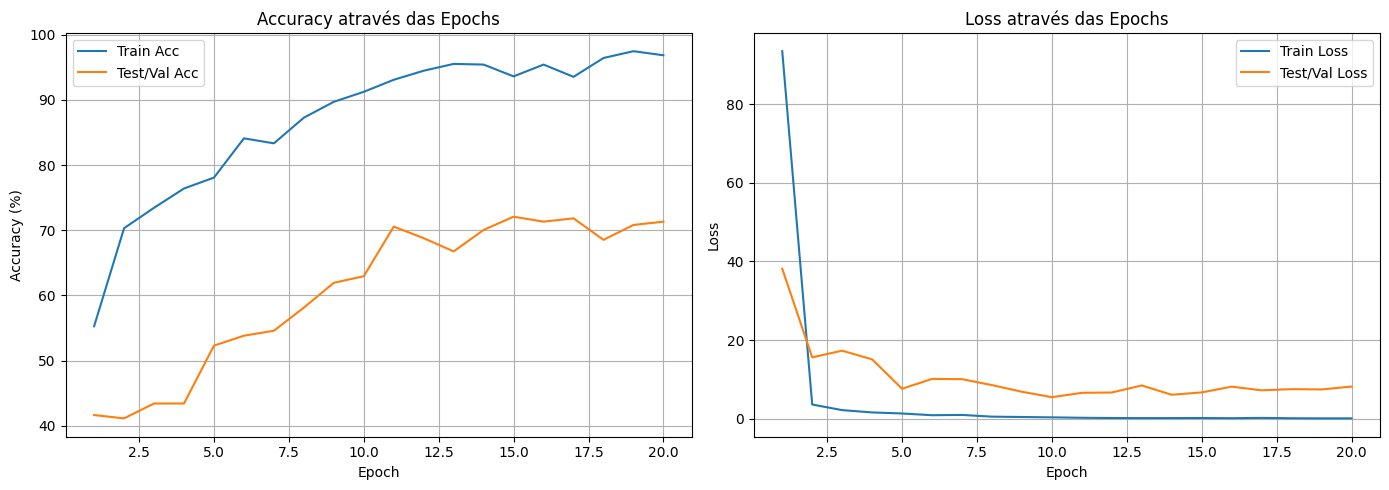

In [ ]:
plot_train_val_history(train_losses_exp, test_losses_exp)

##### Comentarios:

A rede neural evoluiu de forma significativa e saudável ao longo do treinamento, atingindo boa capacidade de generalização com f1-score próximo de 0.70 na validação. Pequenas flutuações no loss de validação e desempenho da classe 0 sugerem espaço para ajustes finos (como class weights, data augmentation ou focal loss). No geral, os resultados são sólidos e promissores.

#### Transfer Learning

Nesta etapa implementaremos o Transfer Learning, onde iremos variar o uso de fine tuning. Utilizaremos a arquitetura ResNet-18 como base, já que traz uma arquitetura profunda e estável, foi originalmente treinada no conjunto de dados ImageNet, sendo possível utilizar esse conhecimento prévio para melhorar a generalização do modelo mesmo em conjuntos de dados médicos relativamente pequenos. Ela permite substituições simples da camada de saída, e  possui aproximadamente 11 milhões de parâmetros, sendo consideravelmente mais leve do que arquiteturas como a ResNet-50. Além disso a ResNet tem sido utilizada em tarefas de classificação de immagens médicas como em:
- https://www.researchgate.net/publication/360330583_ResNet-50_based_deep_neural_network_using_transfer_learning_for_brain_tumor_classification
- https://www.sciencedirect.com/science/article/pii/S1389041718310933
- https://www.sciencedirect.com/science/article/pii/S0010482519302148

##### Fine Tuning todas as camadas

Essa função carrega a arquitetura ResNet-18 com pesos treinados no ImageNet, substitui a última camada para se adequar ao número de classes do seu problema e libera todas as camadas para treinamento

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

def get_pretrained_model_fine_tuning(num_classes):
    model = models.resnet18(weights='DEFAULT')

    # Ativar treinamento para todas as camadas
    for param in model.parameters():
        param.requires_grad = True

    # Substituir a camada final
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

Abaixo estamos obtendo uma versão adaptada da ResNet18 pré-treinada com a camada de saída ajustada para 4 classes. Em seguida enviamos o modelo para o dispositivo de hardware correto (GPU ou CPU). E por fim, exibimos a arquitetura final do modelo, verificando se a camada final foi substituída corretamente e quais camadas fazem parte do modelo.

In [ ]:
model_resnet = get_pretrained_model_fine_tuning(num_classes=4)
model_resnet = model_resnet.to(args['device'])
print(model_resnet)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Aqui é configurado a função de perda e um otimizador com as taxas de aprendizado variando através das camadas da resnet.

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam([
    {'params': model_resnet.layer1.parameters(), 'lr': args['lr'] * 0.01, 'weight_decay': args['weight_decay'] * 0.01},
    {'params': model_resnet.layer2.parameters(), 'lr': args['lr'] * 0.05, 'weight_decay': args['weight_decay'] * 0.05},
    {'params': model_resnet.layer3.parameters(), 'lr': args['lr'] * 0.1,  'weight_decay': args['weight_decay'] * 0.1},
    {'params': model_resnet.layer4.parameters(), 'lr': args['lr'] * 0.2,  'weight_decay': args['weight_decay'] * 0.2},
    {'params': model_resnet.fc.parameters(),    'lr': args['lr'],         'weight_decay': args['weight_decay']},
], lr=0)

Segue a mesma funcionalidade do trecho de código utilizado anteriormente na CNN

In [ ]:


train_losses_exp, test_losses_exp = [], []
best_acc = 0

for epoch in range(args['epoch_num']):

    # Train
    train_losses_exp.append(train_exp(train_loader_exp, model_resnet, epoch))

    # Validate
    result = validate_exp(test_loader_exp, model_resnet, epoch)
    test_losses_exp.append(result)

    val_acc = result[0]
    if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model_resnet.state_dict(), 'best_model_model_resnet_teste.pth')

--89/90--
#################### Train ####################
Epoch 0, Loss: 0.4751 +/- 0.3603, Acc: 84.15
--12/13--
********** Validate **********
Epoch 0, Loss: 1.9503 +/- 0.6516, Acc: 61.68

F1-score: 0.5536
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.24      0.38       100
meningioma_tumor       0.55      0.91      0.69       115
        no_tumor       0.62      0.96      0.76       105
 pituitary_tumor       0.81      0.18      0.29        74

        accuracy                           0.62       394
       macro avg       0.74      0.57      0.53       394
    weighted avg       0.72      0.62      0.55       394

--89/90--
#################### Train ####################
Epoch 1, Loss: 0.2605 +/- 0.1673, Acc: 91.43
--12/13--
********** Validate **********
Epoch 1, Loss: 1.7040 +/- 0.6827, Acc: 70.56

F1-score: 0.6789
Classification Report:
                  precision    recall  f1-score   support

    glioma_tum

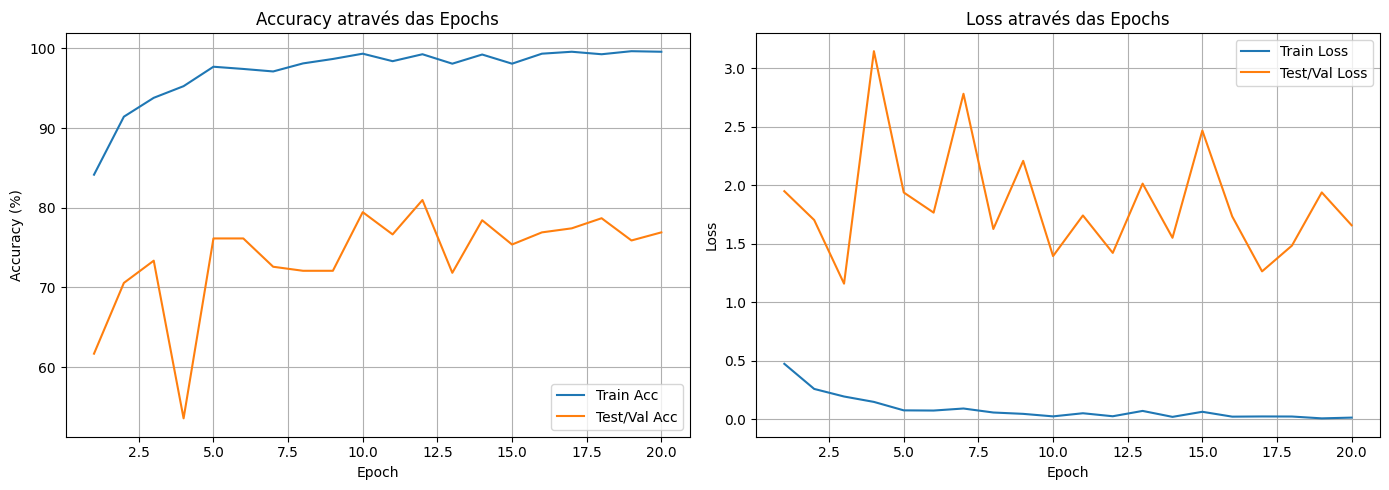

In [ ]:
plot_train_val_history(train_losses_exp, test_losses_exp)

##### Fine tuning a partir da 2 camada

Aqui estamos congelando inicialmente os parâmetros e depois estamos liberando o treinamento a atualização para as camadas 2, 3 e 4, permitindo um fine tuning parcial. De resto seguimos os mesmos passos da etapa anterior

In [ ]:
def get_resnet_finetune(num_classes):
    model = models.resnet18(weights='DEFAULT')
    # Descongelar da layer2 em diante
    for name, param in model.named_parameters():
        param.requires_grad = False
        if 'layer2' in name or 'layer3' in name or 'layer4' in name or 'fc' in name:
            param.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [ ]:
model_resnet_234_not_frozen = get_resnet_finetune(num_classes=4).to(args['device'])


optimizer = torch.optim.Adam([
    {'params': model_resnet_234_not_frozen.layer2.parameters(), 'lr': args['lr'] * 0.05, 'weight_decay': args['weight_decay'] * 0.05},
    {'params': model_resnet_234_not_frozen.layer3.parameters(), 'lr': args['lr'] * 0.1, 'weight_decay': args['weight_decay'] * 0.1},
    {'params': model_resnet_234_not_frozen.layer4.parameters(), 'lr': args['lr'] * 0.2, 'weight_decay': args['weight_decay'] * 0.2},
    {'params': model_resnet_234_not_frozen.fc.parameters(),     'lr': args['lr'],         'weight_decay': args['weight_decay']},
])

In [ ]:
train_losses_exp, test_losses_exp = [], []
best_acc = 0

for epoch in range(args['epoch_num']):

    # Train
    train_losses_exp.append(train_exp(train_loader_exp, model_resnet_234_not_frozen, epoch))

    # Validate
    result = validate_exp(test_loader_exp, model_resnet_234_not_frozen, epoch)
    test_losses_exp.append(result)
    val_acc = result[0]
    if val_acc > best_acc:
          best_acc_adj = val_acc
          torch.save(model_resnet_234_not_frozen.state_dict(), 'best_model_model_resnet_234_not_frozen.pth')



--89/90--
#################### Train ####################
Epoch 0, Loss: 0.5870 +/- 0.4075, Acc: 81.57
--12/13--
********** Validate **********
Epoch 0, Loss: 1.9407 +/- 0.3844, Acc: 55.08

F1-score: 0.5139
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.75      0.21      0.33       100
meningioma_tumor       0.90      0.32      0.47       115
        no_tumor       0.42      0.90      0.57       105
 pituitary_tumor       0.65      0.88      0.75        74

        accuracy                           0.55       394
       macro avg       0.68      0.58      0.53       394
    weighted avg       0.69      0.55      0.51       394

--89/90--
#################### Train ####################
Epoch 1, Loss: 0.2178 +/- 0.1630, Acc: 93.14
--12/13--
********** Validate **********
Epoch 1, Loss: 1.3666 +/- 0.5758, Acc: 71.32

F1-score: 0.6969
Classification Report:
                  precision    recall  f1-score   support

    glioma_tum

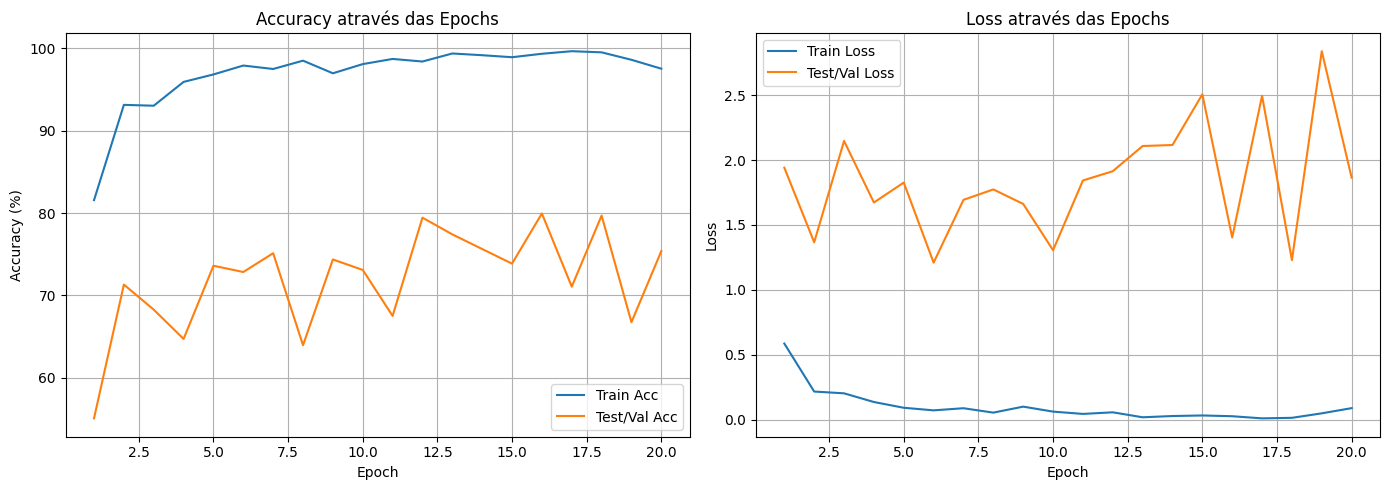

In [ ]:
plot_train_val_history(train_losses_exp, test_losses_exp)

##### Fine tuning camadas 3, 4 e de classificação

Aqui estamos congelando inicialmente os parâmetros e depois estamos liberando o treinamento a atualização para as camadas 3 e 4, permitindo um fine tuning parcial. De resto seguimos os mesmos passos da etapa anterior

In [ ]:
def get_pretrained_model_fine_tuning(num_classes):
    model = models.resnet18(weights='DEFAULT')

    # Congelar as camadas
    for param in model.parameters():
        param.requires_grad = False

    for param in model.layer3.parameters():
        param.requires_grad = True

    for param in model.layer4.parameters():
        param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [ ]:
# Substituir a CNN atual pelo modelo treinado
model_resnet_exp = get_pretrained_model_fine_tuning(num_classes=4)  # Ajuste o número de classes conforme seu dataset
model_resnet_exp = model_resnet_exp.to(args['device'])

In [ ]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = torch.optim.Adam([
            {'params': model_resnet_exp.layer3.parameters(), 'lr': args['lr']*0.1, 'weight_decay': args['weight_decay']*0.1},
            {'params': model_resnet_exp.layer4.parameters(), 'lr':args['lr']*0.2, 'weight_decay': args['weight_decay']*0.2},
            {'params': model_resnet_exp.fc.parameters(), 'lr': args['lr'], 'weight_decay': args['weight_decay']}
])

In [ ]:
train_losses_exp, test_losses_exp = [], []
best_acc = 0

for epoch in range(args['epoch_num']):

    # Train
    train_losses_exp.append(train_exp(train_loader_exp, model_resnet_exp, epoch))

    # Validate
    result = validate_exp(test_loader_exp, model_resnet_exp, epoch)
    test_losses_exp.append(result)

    val_acc = result[0]
    if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model_resnet_exp.state_dict(), 'best_model_model_resnet_exp_teste.pth')

--89/90--
#################### Train ####################
Epoch 0, Loss: 0.5941 +/- 0.5180, Acc: 81.81
--12/13--
********** Validate **********
Epoch 0, Loss: 3.2799 +/- 0.9161, Acc: 45.69

F1-score: 0.4084
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.14      0.25       100
meningioma_tumor       0.67      0.16      0.25       115
        no_tumor       0.34      1.00      0.51       105
 pituitary_tumor       0.98      0.58      0.73        74

        accuracy                           0.46       394
       macro avg       0.75      0.47      0.43       394
    weighted avg       0.72      0.46      0.41       394

--89/90--
#################### Train ####################
Epoch 1, Loss: 0.2414 +/- 0.2037, Acc: 92.06
--12/13--
********** Validate **********
Epoch 1, Loss: 1.9399 +/- 0.6687, Acc: 60.66

F1-score: 0.5295
Classification Report:
                  precision    recall  f1-score   support

    glioma_tum

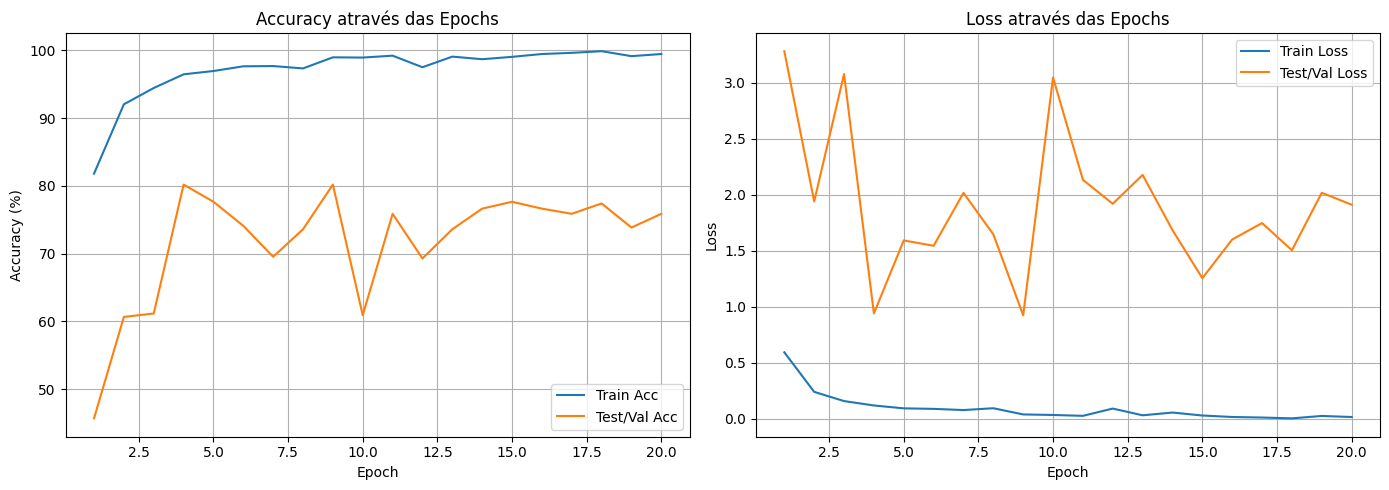

In [ ]:
plot_train_val_history(train_losses_exp, test_losses_exp)

#### Feature Extractor

Para este experimento foi utilizada ResNet18 pré-treinada como extrator de características onde, a partir das representações vetoriais obtidas, treinou-se um classificador Random Forest para realizar a predição dos rótulos das imagens.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Nesse passo é realizado o mesmo fluxo da função de validação implementado anteriormente. No entanto, não é preciso calcular a predição final, apenas armazenar as saídas da rede.

In [ ]:
def extrai_caracteristicas(net_, loader):
    net_.eval()

    feat_list, rotulo_list = [], []
    with torch.no_grad():
        for k, batch in enumerate(loader):
            print('\r--{0}/{1}--'.format(k, len(loader)), end='', flush=True)

            dado, rotulo = batch
            dado = dado.to(args['device'])
            rotulo = rotulo.to(args['device'])

            caracteristica = net_(dado)
            print(f'\nBatch {k} - Características shape: {caracteristica.shape}')

            feat_list.append(caracteristica.detach().cpu().numpy())
            rotulo_list.append(rotulo.detach().cpu().numpy())

        feat_list = np.concatenate(feat_list, axis=0)
        rotulo_list = np.concatenate(rotulo_list)
    return feat_list, rotulo_list

Esta classe vai usar uma ResNet18 pré-treinada, e remover a camada final (fc) para que a saída seja o vetor de características, e não as classes.
- nn.Identity(): substitui a camada fc por uma identidade, ou seja, retorna as features extraídas antes da classificação

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, device='cuda'):
        super(ResNet18FeatureExtractor, self).__init__()
        self.device = device

        # Carrega a resnet18 pré-treinada
        self.model = models.resnet18(weights='DEFAULT')

        # Remove a camada fc
        self.model.fc = nn.Identity()

        # Envia para o device e define como eval
        self.model = self.model.to(self.device)
        self.model.eval()

    def forward(self, x):
        return self.model(x)


In [ ]:
# Cria o extrator
net_resnet_ext = ResNet18FeatureExtractor(device=args['device'])

# Extrai características do treino e teste
print('Load train')
train_X, train_Y = extrai_caracteristicas(net_resnet_ext, train_loader_exp)

print('\nLoad test')
test_X, test_Y = extrai_caracteristicas(net_resnet_ext, test_loader_exp)


Load train
--0/45--
Batch 0 - Características shape: torch.Size([64, 512])
--1/45--
Batch 1 - Características shape: torch.Size([64, 512])
--2/45--
Batch 2 - Características shape: torch.Size([64, 512])
--3/45--
Batch 3 - Características shape: torch.Size([64, 512])
--4/45--
Batch 4 - Características shape: torch.Size([64, 512])
--5/45--
Batch 5 - Características shape: torch.Size([64, 512])
--6/45--
Batch 6 - Características shape: torch.Size([64, 512])
--7/45--
Batch 7 - Características shape: torch.Size([64, 512])
--8/45--
Batch 8 - Características shape: torch.Size([64, 512])
--9/45--
Batch 9 - Características shape: torch.Size([64, 512])
--10/45--
Batch 10 - Características shape: torch.Size([64, 512])
--11/45--
Batch 11 - Características shape: torch.Size([64, 512])
--12/45--
Batch 12 - Características shape: torch.Size([64, 512])
--13/45--
Batch 13 - Características shape: torch.Size([64, 512])
--14/45--
Batch 14 - Características shape: torch.Size([64, 512])
--15/45--
Batch 15 


[3] Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.26      0.40       100
           1       0.63      0.93      0.75       115
           2       0.74      0.95      0.83       105
           3       0.86      0.69      0.77        74

    accuracy                           0.72       394
   macro avg       0.78      0.71      0.69       394
weighted avg       0.77      0.72      0.69       394



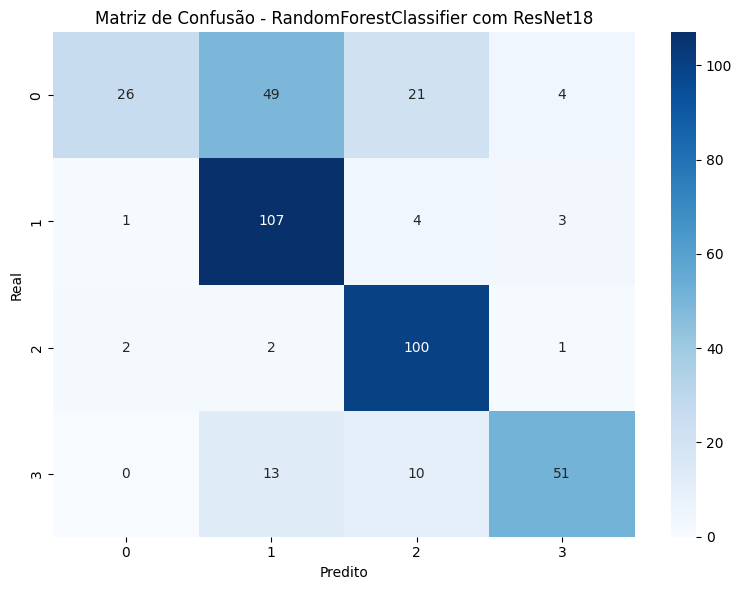

In [ ]:
# Normalização (StandardScaler é essencial para SVM)
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# Classificador RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_X_scaled, train_Y)

# Avaliação
pred_Y = clf.predict(test_X_scaled)

print("\n[3] Classification Report:\n")
print(classification_report(test_Y, pred_Y))

# Matriz de confusão
conf_mat = confusion_matrix(test_Y, pred_Y)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - RandomForestClassifier com ResNet18")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

Como podemos ver, o extrator de características obteve uma acurácia geral de 72% e apresentou bom desempenho nas classes meningioma e sem tumor, o que para contextos médicos é preocupante pois estamos deixando passar tumores como não tumores. Além disso, o modelo teve baixo recall para a classe glioma tumor e desempenho moderado para pituitary tumor, indicando que ainda há risco relevante de diagnósticos incorretos nessas categorias. Ajustes como balanceamento de classes e penalização de falsos negativos poderiam ser considerados para melhorar a sensibilidade do modelo.

Com relação aos demais modelos observamos uma melhora do modelo da cnn básica e ao utiliar o transfer learning temos uma ótima melhora do conjunto geral. Mas podemos ver um claro overfit dos modelos acima mesmo utilizando regularização e camadas de dropout, logo teremos que focar no conjunto de dados e fazer alguns ajustes como por exemplo dividir o conjunto de treinamento em treinamento e validação e utilizar o modelo que melhor performar neste meio com a melhor acurácia geral.

### Nesta etapa iremos dividir o dataset de treino em treinamento e validação

In [ ]:
from torch.utils.data import random_split

full_train_dataset = datasets.ImageFolder(root=train_path)
# Criar conjunto de validação separado do treino (20% para validação)
# Divisão em treino e validação
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

# Aplicando transformações após split
train_subset.dataset.transform = transform_train_exp
val_subset.dataset.transform = transform_val_exp
test_dataset_exp_adj = datasets.ImageFolder(root=test_path, transform=transform_val_exp)

train_loader_exp_adj = DataLoader(train_subset, batch_size=args['batch_size'], shuffle=True)
val_loader_exp_adj = DataLoader(val_subset, batch_size=args['batch_size'], shuffle=False)

test_loader_exp_adj = DataLoader(test_dataset_exp_adj, batch_size=args['batch_size'], shuffle=True)

### Testando com o novo ajutes da distribuição dos dados

#### CNN Novo Teste

In [ ]:
# Subindo no hardware de GPU (se disponível)
model_novo_teste_adj = CNN_NovoTeste().to(args['device'])
optimizer = Adam(model_novo_teste_adj.parameters(), lr=args['lr'])
criterion = nn.CrossEntropyLoss().to(args['device'])

In [ ]:
train_losses_exp, test_losses_exp = [], []
best_acc = 0

for epoch in range(args['epoch_num']):

    # Train
    train_losses_exp.append(train_exp(train_loader_exp_adj, model_novo_teste_adj, epoch))

    # Validate
    result = validate_exp(val_loader_exp_adj, model_novo_teste_adj, epoch)
    test_losses_exp.append(result)

    val_acc = result[0]
    if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model_novo_teste_adj.state_dict(), 'best_model_model_novo_teste_adj_teste.pth')

--71/72--
#################### Train ####################
Epoch 0, Loss: 102.5648 +/- 216.5802, Acc: 49.96
--17/18--
********** Validate **********
Epoch 0, Loss: 12.8252 +/- 5.6833, Acc: 63.94

F1-score: 0.6288
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.77      0.48      0.59       175
meningioma_tumor       0.51      0.48      0.49       159
        no_tumor       0.57      0.78      0.66        88
 pituitary_tumor       0.70      0.91      0.79       152

        accuracy                           0.64       574
       macro avg       0.64      0.66      0.64       574
    weighted avg       0.65      0.64      0.63       574

--71/72--
#################### Train ####################
Epoch 1, Loss: 9.2192 +/- 5.3607, Acc: 67.90
--17/18--
********** Validate **********
Epoch 1, Loss: 7.1256 +/- 3.1583, Acc: 66.72

F1-score: 0.6265
Classification Report:
                  precision    recall  f1-score   support

    gliom

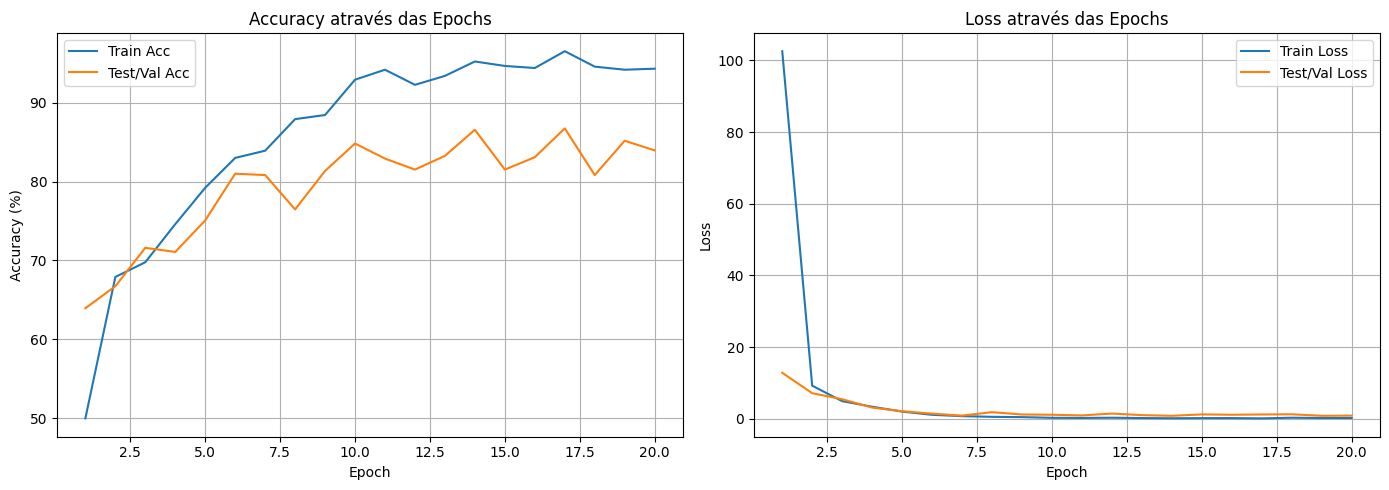

In [ ]:
plot_train_val_history(train_losses_exp, test_losses_exp)

In [ ]:
# Carrega o melhor modelo salvo
model_novo_teste_adj.load_state_dict(torch.load('best_model_model_novo_teste_adj_teste.pth'))
model_novo_teste_adj.eval()

# Avaliação no conjunto de teste
test_acc, test_loss, _ = validate_exp(test_loader_exp_adj, model_novo_teste_adj, epoch=0)
print(f"Desempenho no conjunto de teste: Acc={test_acc:.2f}% | Loss={test_loss:.4f}")


--12/13--
********** Validate **********
Epoch 0, Loss: 10.8289 +/- 4.7405, Acc: 61.68

F1-score: 0.5688
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.15      0.26       100
meningioma_tumor       0.64      0.74      0.69       115
        no_tumor       0.53      1.00      0.69       105
 pituitary_tumor       0.83      0.51      0.63        74

        accuracy                           0.62       394
       macro avg       0.73      0.60      0.57       394
    weighted avg       0.72      0.62      0.57       394

Desempenho no conjunto de teste: Acc=61.68% | Loss=10.8289


#### Para o Fine tuning de todas as camadas

In [ ]:
model_resnet_adj = get_pretrained_model_fine_tuning(num_classes=4)
model_resnet_adj = model_resnet_adj.to(args['device'])

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam([
    {'params': model_resnet_adj.layer1.parameters(), 'lr': args['lr'] * 0.01, 'weight_decay': args['weight_decay'] * 0.01},
    {'params': model_resnet_adj.layer2.parameters(), 'lr': args['lr'] * 0.05, 'weight_decay': args['weight_decay'] * 0.05},
    {'params': model_resnet_adj.layer3.parameters(), 'lr': args['lr'] * 0.1,  'weight_decay': args['weight_decay'] * 0.1},
    {'params': model_resnet_adj.layer4.parameters(), 'lr': args['lr'] * 0.2,  'weight_decay': args['weight_decay'] * 0.2},
    {'params': model_resnet_adj.fc.parameters(),    'lr': args['lr'],         'weight_decay': args['weight_decay']},
], lr=0)

In [ ]:
train_losses_exp, test_losses_exp = [], []
best_acc = 0

for epoch in range(args['epoch_num']):

    # Train
    train_losses_exp.append(train_exp(train_loader_exp_adj, model_resnet_adj, epoch))

    # Validate
    result = validate_exp(val_loader_exp_adj, model_resnet_adj, epoch)
    test_losses_exp.append(result)

    val_acc = result[0]
    if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model_resnet_adj.state_dict(), 'best_model_model_resnet_adj_teste.pth')

--71/72--
#################### Train ####################
Epoch 0, Loss: 0.5621 +/- 0.4612, Acc: 82.53
--17/18--
********** Validate **********
Epoch 0, Loss: 0.8050 +/- 0.5410, Acc: 85.54

F1-score: 0.8514
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.95      0.91       175
meningioma_tumor       0.94      0.70      0.80       159
        no_tumor       0.91      0.72      0.80        88
 pituitary_tumor       0.77      0.99      0.87       152

        accuracy                           0.86       574
       macro avg       0.87      0.84      0.84       574
    weighted avg       0.87      0.86      0.85       574

--71/72--
#################### Train ####################
Epoch 1, Loss: 0.2393 +/- 0.1800, Acc: 92.42
--17/18--
********** Validate **********
Epoch 1, Loss: 0.2850 +/- 0.3492, Acc: 93.90

F1-score: 0.9389
Classification Report:
                  precision    recall  f1-score   support

    glioma_tum

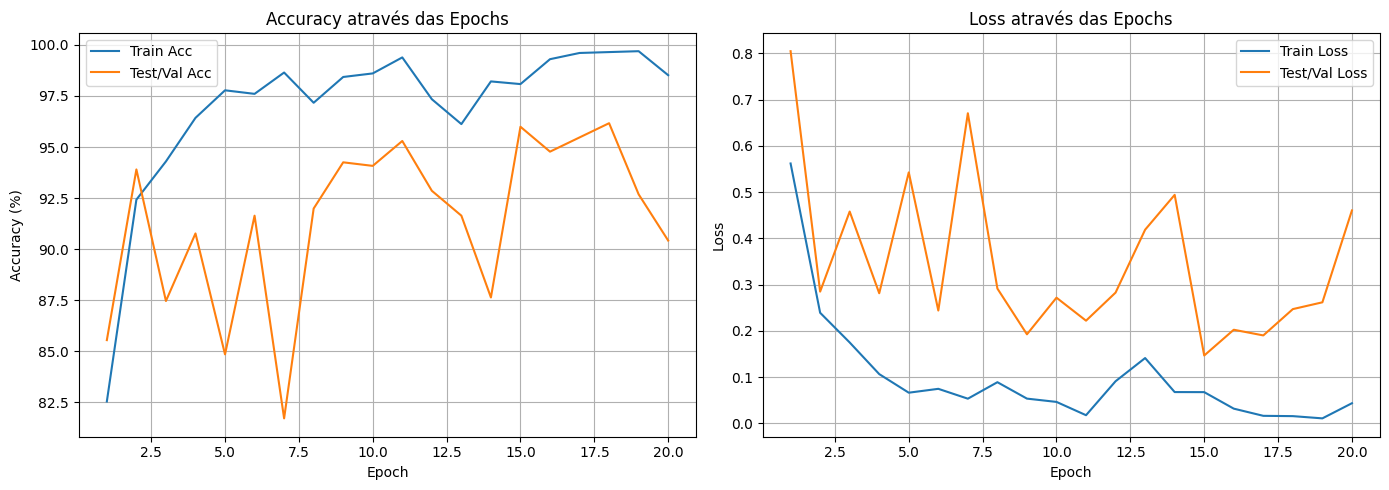

In [ ]:
plot_train_val_history(train_losses_exp, test_losses_exp)

In [ ]:
# Carrega o melhor modelo salvo
model_resnet_adj.load_state_dict(torch.load('best_model_model_resnet_adj_teste.pth'))
model_resnet_adj.eval()

# Avaliação no conjunto de teste
test_acc, test_loss, _ = validate_exp(test_loader_exp_adj, model_resnet_adj, epoch=0)
print(f"Desempenho no conjunto de teste: Acc={test_acc:.2f}% | Loss={test_loss:.4f}")

--12/13--
********** Validate **********
Epoch 0, Loss: 1.7752 +/- 0.5940, Acc: 78.68

F1-score: 0.7525
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.29      0.45       100
meningioma_tumor       0.68      0.98      0.81       115
        no_tumor       0.80      1.00      0.89       105
 pituitary_tumor       0.93      0.85      0.89        74

        accuracy                           0.79       394
       macro avg       0.85      0.78      0.76       394
    weighted avg       0.84      0.79      0.75       394

Desempenho no conjunto de teste: Acc=78.68% | Loss=1.7752


#### Fine tuning para as camadas 2, 3 e 4

In [ ]:
model_resnet_234_not_frozen_adj = get_resnet_finetune(num_classes=4).to(args['device'])


optimizer = torch.optim.Adam([
    {'params': model_resnet_234_not_frozen_adj.layer2.parameters(), 'lr': args['lr'] * 0.05, 'weight_decay': args['weight_decay'] * 0.05},
    {'params': model_resnet_234_not_frozen_adj.layer3.parameters(), 'lr': args['lr'] * 0.1, 'weight_decay': args['weight_decay'] * 0.1},
    {'params': model_resnet_234_not_frozen_adj.layer4.parameters(), 'lr': args['lr'] * 0.2, 'weight_decay': args['weight_decay'] * 0.2},
    {'params': model_resnet_234_not_frozen_adj.fc.parameters(),     'lr': args['lr'],         'weight_decay': args['weight_decay']},
])

In [ ]:
train_losses_exp, test_losses_exp = [], []
best_acc = 0

for epoch in range(args['epoch_num']):

    # Train
    train_losses_exp.append(train_exp(train_loader_exp_adj, model_resnet_234_not_frozen_adj, epoch))

    # Validate
    result = validate_exp(val_loader_exp_adj, model_resnet_234_not_frozen_adj, epoch)
    test_losses_exp.append(result)
    val_acc = result[0]
    if val_acc > best_acc:
          best_acc_adj = val_acc
          torch.save(model_resnet_234_not_frozen_adj.state_dict(), 'best_model_model_resnet_234_not_frozen_adj.pth')



--71/72--
#################### Train ####################
Epoch 0, Loss: 0.5698 +/- 0.3633, Acc: 80.14
--17/18--
********** Validate **********
Epoch 0, Loss: 0.5495 +/- 0.1864, Acc: 84.84

F1-score: 0.8500
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.65      0.79       175
meningioma_tumor       0.67      0.97      0.79       159
        no_tumor       0.93      0.93      0.93        88
 pituitary_tumor       0.98      0.89      0.93       152

        accuracy                           0.85       574
       macro avg       0.89      0.86      0.86       574
    weighted avg       0.89      0.85      0.85       574

--71/72--
#################### Train ####################
Epoch 1, Loss: 0.2599 +/- 0.1618, Acc: 91.38
--17/18--
********** Validate **********
Epoch 1, Loss: 0.5198 +/- 0.4036, Acc: 85.71

F1-score: 0.8600
Classification Report:
                  precision    recall  f1-score   support

    glioma_tum

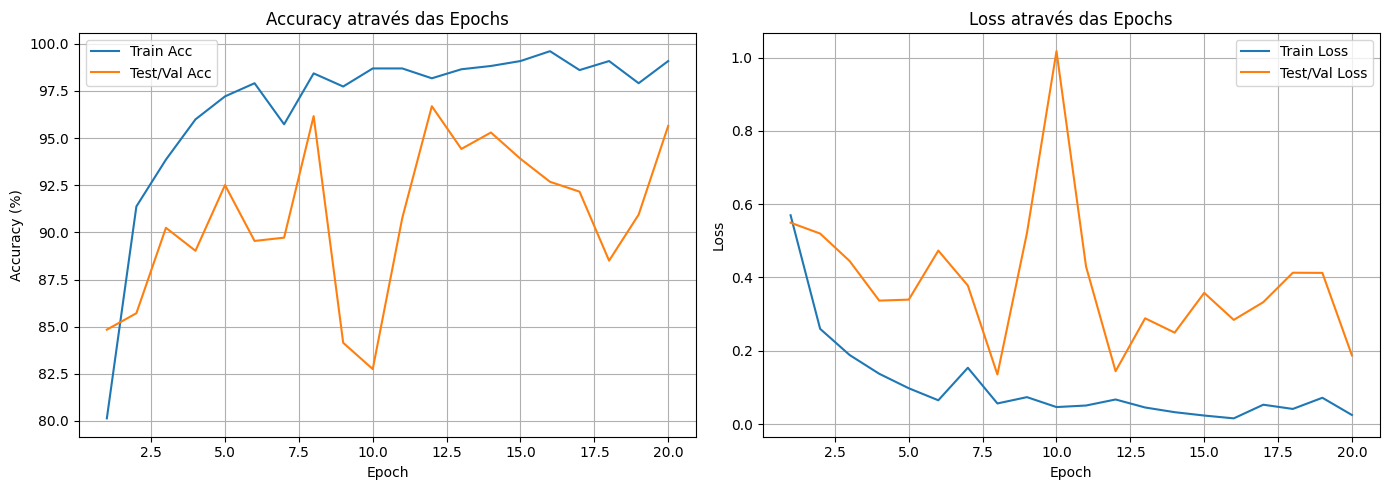

In [ ]:
plot_train_val_history(train_losses_exp, test_losses_exp)

In [ ]:
# Carrega o melhor modelo salvo
model_resnet_234_not_frozen_adj.load_state_dict(torch.load('best_model_model_resnet_234_not_frozen_adj.pth'))
model_resnet_234_not_frozen_adj.eval()

# Avaliação no conjunto de teste
test_acc, test_loss, _ = validate_exp(test_loader_exp_adj, model_resnet_234_not_frozen_adj, epoch=0)
print(f"Desempenho no conjunto de teste: Acc={test_acc:.2f}% | Loss={test_loss:.4f}")

--12/13--
********** Validate **********
Epoch 0, Loss: 1.2294 +/- 0.5483, Acc: 80.96

F1-score: 0.7908
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.42      0.58       100
meningioma_tumor       0.71      1.00      0.83       115
        no_tumor       0.83      0.98      0.90       105
 pituitary_tumor       0.94      0.80      0.86        74

        accuracy                           0.81       394
       macro avg       0.85      0.80      0.79       394
    weighted avg       0.84      0.81      0.79       394

Desempenho no conjunto de teste: Acc=80.96% | Loss=1.2294


#### Para o fine tuning das camadas 3 e 4

In [ ]:
# Substituir a CNN atual pelo modelo treinado
model_resnet_34_exp_adj = get_pretrained_model_fine_tuning(num_classes=4)  # Ajuste o número de classes conforme seu dataset
model_resnet_34_exp_adj = model_resnet_34_exp_adj.to(args['device'])

In [ ]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = torch.optim.Adam([
            {'params': model_resnet_34_exp_adj.layer3.parameters(), 'lr': args['lr']*0.1, 'weight_decay': args['weight_decay']*0.1},
            {'params': model_resnet_34_exp_adj.layer4.parameters(), 'lr':args['lr']*0.2, 'weight_decay': args['weight_decay']*0.2},
            {'params': model_resnet_34_exp_adj.fc.parameters(), 'lr': args['lr'], 'weight_decay': args['weight_decay']}
])

In [ ]:
train_losses_exp, test_losses_exp = [], []
best_acc = 0

for epoch in range(args['epoch_num']):

    # Train
    train_losses_exp.append(train_exp(train_loader_exp_adj, model_resnet_34_exp_adj, epoch))

    # Validate
    result = validate_exp(val_loader_exp_adj, model_resnet_34_exp_adj, epoch)
    test_losses_exp.append(result)

    val_acc = result[0]
    if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model_resnet_34_exp_adj.state_dict(), 'best_model_model_resnet_34_exp_adj_teste.pth')

--71/72--
#################### Train ####################
Epoch 0, Loss: 0.6475 +/- 0.3624, Acc: 79.05
--17/18--
********** Validate **********
Epoch 0, Loss: 0.4882 +/- 0.2613, Acc: 85.89

F1-score: 0.8590
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.76      0.86       175
meningioma_tumor       0.75      0.87      0.81       159
        no_tumor       0.92      0.83      0.87        88
 pituitary_tumor       0.84      0.98      0.91       152

        accuracy                           0.86       574
       macro avg       0.88      0.86      0.86       574
    weighted avg       0.87      0.86      0.86       574

--71/72--
#################### Train ####################
Epoch 1, Loss: 0.2427 +/- 0.1482, Acc: 92.29
--17/18--
********** Validate **********
Epoch 1, Loss: 0.2980 +/- 0.1358, Acc: 87.11

F1-score: 0.8747
Classification Report:
                  precision    recall  f1-score   support

    glioma_tum

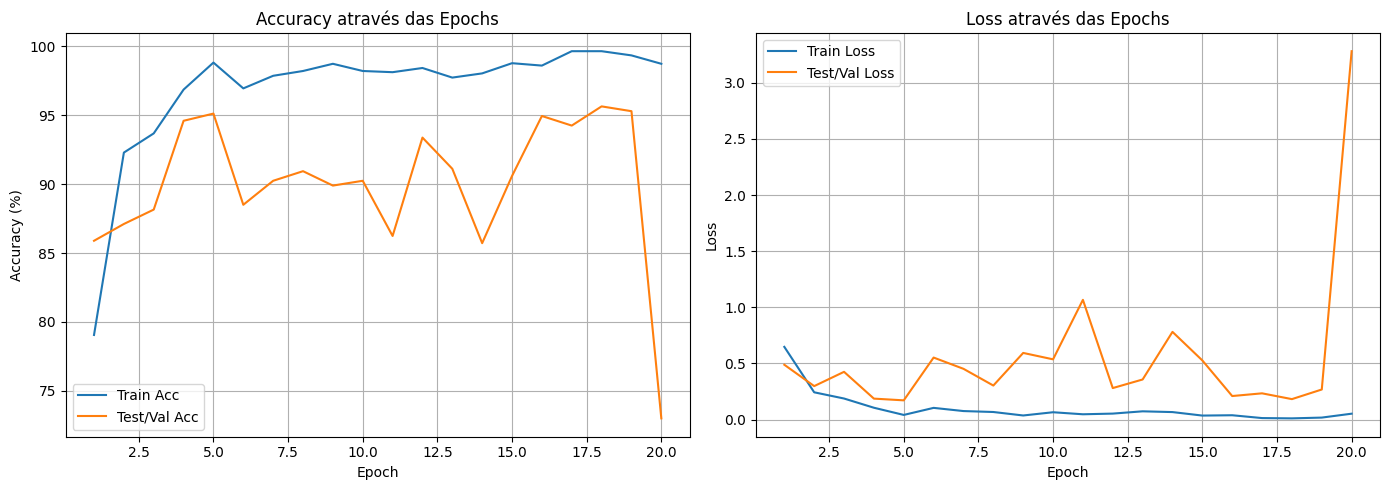

In [ ]:
plot_train_val_history(train_losses_exp, test_losses_exp)

In [ ]:
# Carrega o melhor modelo salvo
model_resnet_34_exp_adj.load_state_dict(torch.load('best_model_model_resnet_34_exp_adj_teste.pth'))
model_resnet_34_exp_adj.eval()

# Avaliação no conjunto de teste
test_acc, test_loss, _ = validate_exp(test_loader_exp_adj, model_resnet_34_exp_adj, epoch=0)
print(f"Desempenho no conjunto de teste: Acc={test_acc:.2f}% | Loss={test_loss:.4f}")

--12/13--
********** Validate **********
Epoch 0, Loss: 1.5603 +/- 0.6732, Acc: 75.13

F1-score: 0.7114
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.24      0.38       100
meningioma_tumor       0.76      0.97      0.85       115
        no_tumor       0.65      1.00      0.79       105
 pituitary_tumor       0.95      0.74      0.83        74

        accuracy                           0.75       394
       macro avg       0.81      0.74      0.71       394
    weighted avg       0.80      0.75      0.71       394

Desempenho no conjunto de teste: Acc=75.13% | Loss=1.5603


Novamente obtivemos bons resultados no conjunto de treinamento e validação. Para o conjunto de teste houve até uma melhora para alguns casos com relação ao transfer learning, no entando, ainda existe uma indicação de má generalização do modelo para o conjunto de testes, o que nos resta tentar entender com o grad-cam como o modelo esta tomando as decisões no conjunto de teste.

### Utilizando o Grad Cam para o modelo com melhor acurácia no conjunto de teste

In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 18.9 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
def generate_gradcam(model, image_tensor, target_class, device='cuda'):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    final_conv_layer = model.layer4[-1]
    hook_fwd = final_conv_layer.register_forward_hook(forward_hook)
    hook_bwd = final_conv_layer.register_backward_hook(backward_hook)

    output = model(image_tensor)
    model.zero_grad()
    target = output[0, target_class]
    target.backward()

    grads = gradients[0].cpu().detach().numpy()[0]
    acts = activations[0].cpu().detach().numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    gradcam = np.sum(weights[:, np.newaxis, np.newaxis] * acts, axis=0)

    gradcam = np.maximum(gradcam, 0)
    gradcam /= gradcam.max()

    hook_fwd.remove()
    hook_bwd.remove()

    return gradcam

In [ ]:
def show_gradcam_on_image(image_tensor, gradcam, alpha=0.5):
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    gradcam_resized = cv2.resize(gradcam, (image_np.shape[1], image_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap * alpha + image_np
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Imagem Original")
    plt.imshow(image_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM")
    plt.imshow(gradcam_resized, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Sobreposição")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

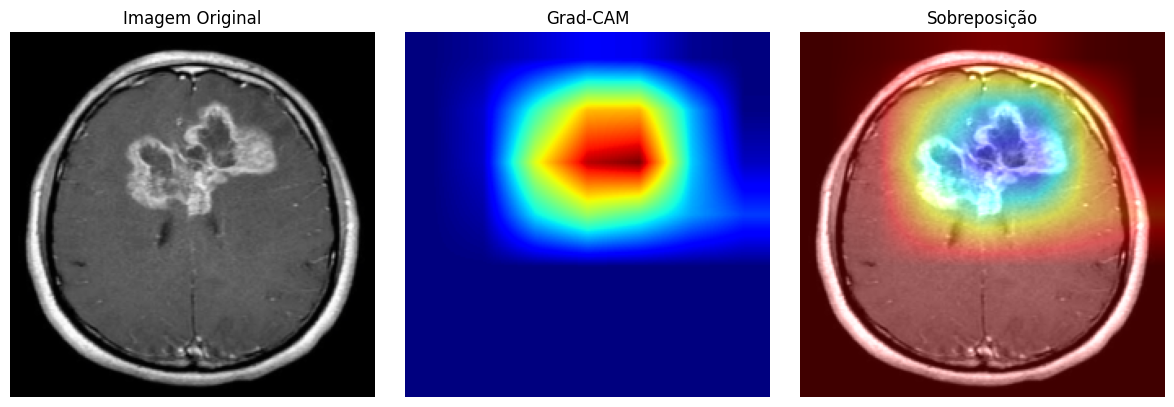

In [ ]:
model_resnet_234_not_frozen_adj.eval()
img, true_label = test_dataset_exp_adj[80]  # imagem e rótulo verdadeiro
output = model_resnet_234_not_frozen_adj(img.unsqueeze(0).to(args['device']))
pred_class = torch.argmax(output).item()
gradcam = generate_gradcam(model_resnet_234_not_frozen_adj, img, target_class=pred_class, device=args['device'])
show_gradcam_on_image(img, gradcam)


In [ ]:
def show_gradcams(model, dataset, class_names, indices=[0, 1, 2], device='cuda'):
    model.eval()
    for idx in indices:
        image_tensor, true_label = dataset[idx]
        output = model(image_tensor.unsqueeze(0).to(device))
        pred_class = torch.argmax(output).item()

        gradcam = generate_gradcam(model, image_tensor, pred_class, device=device)

        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        image_np = np.clip(image_np, 0, 1)

        gradcam_resized = cv2.resize(gradcam, (image_np.shape[1], image_np.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_resized), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        overlay = heatmap * 0.5 + image_np
        overlay = np.clip(overlay, 0, 1)

        plt.figure(figsize=(10, 3))
        plt.suptitle(f"Verdadeira: {class_names[true_label]} | Predita: {class_names[pred_class]}", fontsize=14)
        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title("Imagem Original")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gradcam_resized, cmap='jet')
        plt.title("Grad-CAM")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title("Sobreposição")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


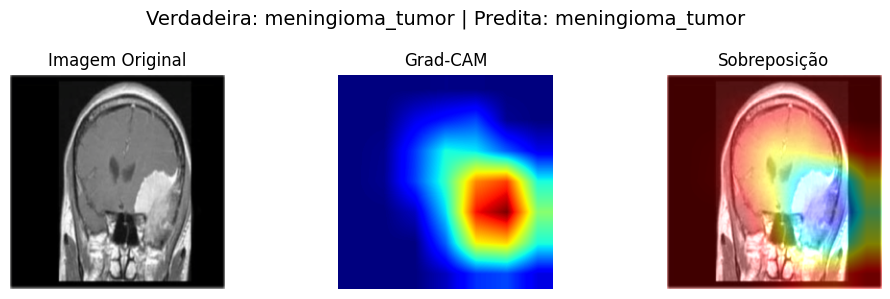

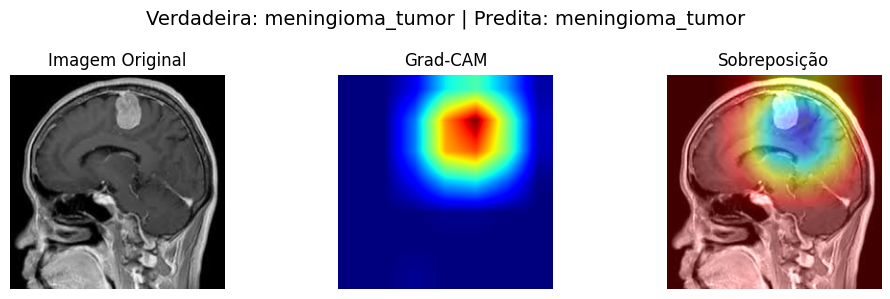

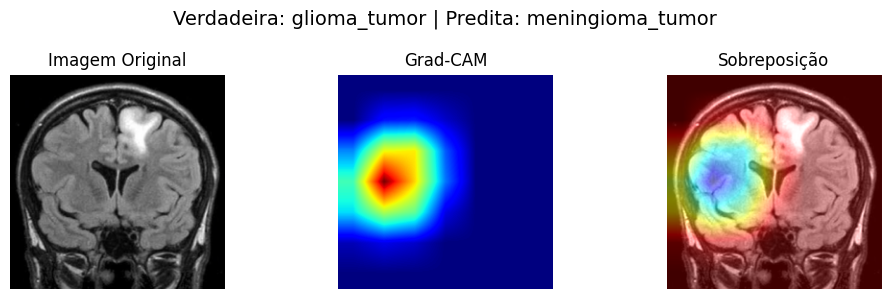

In [ ]:
# Definindo os nomes das classes na ordem correta, observamos isso anteriormente
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

show_gradcams(model_resnet_234_not_frozen_adj, test_dataset_exp_adj, class_names, indices=[100, 156, 7], device=args['device'])


O overfitting identificado no modelo pode ser parcialmente explicado pela natureza e qualidade dos dados utilizados. As imagens do conjunto de dados estão no formato JPG, que é um formato comum para imagens genéricas, mas não ideais para aplicações médicas como a análise de ressonância magnética (MRI). Isso implica em uma série de limitações técnicas que afetam diretamente a generalização do modelo.

Formatos como JPG utilizam compressão com perda, o que resulta na eliminação de detalhes sutis da imagem, especialmente nas regiões com pequenas variações de intensidade — justamente onde podem existir características importantes para o diagnóstico, como a delimitação de tumores ou alterações nos tecidos. Além disso, essa compressão pode introduzir artefatos visuais, como blocos ou suavizações, que confundem o modelo durante o treinamento e a inferência.

Imagens médicas em formatos próprios (como DICOM) contêm valores de intensidade calibrados, frequentemente associados à densidade dos tecidos, permitindo que modelos aprendam padrões consistentes. Já em formatos como JPG, os valores de pixel são afetados por transformações de contraste, brilho e escala não padronizadas, fazendo com que a distribuição estatística das imagens varie significativamente entre arquivos, inclusive entre conjuntos de treino, validação e teste.

Formatos médicos como DICOM incluem informações contextuais e técnicas da imagem, como resolução real, parâmetros de aquisição e localização anatômica, que poderiam ser utilizadas para enriquecer o processo de treinamento ou padronizar a análise. A ausência desses metadados em formatos genéricos compromete a consistência entre amostras e dificulta o aprendizado robusto.

Como o modelo é treinado em um subconjunto específico de imagens, ele tende a memorizar características específicas desses arquivos, ao invés de aprender representações generalizáveis da anatomia cerebral. Isso explica o bom desempenho nos dados de treino/validação e a queda no teste.

#### Considerações Finais
A variação nos formatos de imagem e a ausência de padronização contribuem para um cenário de distribuições inconsistentes entre os conjuntos, aumentando o risco de overfitting e dificultando a generalização. Recomenda-se, para trabalhos futuros, o uso de formatos médicos apropriados (como DICOM), ou ao menos a padronização rigorosa dos dados por meio de normalização, equalização de histograma e compressão controlada, além do uso de técnicas de data augmentation que simulem diferentes condições de aquisição.